# 2-patch scenarios

Comparison between time series with 2 patches. This notebook is used to run and plot simulations with only two patches in the landscapes. Homogeneous and heterogeneous scenarios with or without evolution. Also including the parameter tests presented in Appendix F of the thesis and the extreme heterogeneity scenarios of Appendix E.

In [1]:
# load needed packages
import random as rd
import numpy as np
import pandas as pd
from scipy import integrate as integ
from scipy import signal as signal
import spatial_eco_evo_functions_random as fct_rgg
import spatial_eco_evo_functions_grid as fct_grid
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Switch evolution on or off:

To switch on or off the evolution for all following cells set evolution "True" or "False" here. To switch it on or off for a particular cell uncomment the respective line at the top of the simulation cells.

In [2]:
evolution = True # True or False

## Define the landscape:

In [3]:
# set patch coordinates and delta matrix
N = 2
x_coord = np.array([0.4, 0.6])
y_coord = np.array([0.5, 0.5])
delta = np.array([[0.0, 0.2], [0.2, 0.0]])

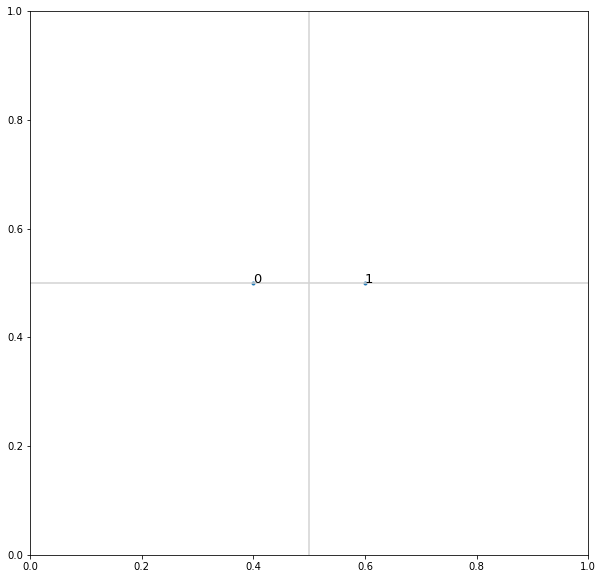

In [4]:
# plot
plt.figure(figsize=(10,10))
plt.plot(x_coord, y_coord, ".")
for i in range(N):
    text(x_coord[i], y_coord[i], i, size=13)
plt.plot(np.linspace(0,1,10), np.linspace(0.5,0.5,10), 'lightgrey')
plt.plot(np.linspace(0.5,0.5,10), np.linspace(0,1,10), 'lightgrey')
plt.xlim(0,1)
plt.ylim(0,1);

## Standard parameter set

In [5]:
# set ecological parameter values:
gamma_A = 0.2            # interaction benefit provided by the pollinator
gamma_P = 1              # interaction benefit provided by the pollinator
c_A = 1                  # intraspecific competition strength of the pollinator 
s = 2.5                  # trade-off shape form factor

# dispersal rate
d = 0.2

# initial pollinator growth rate
r_Aorig = 0.6            # for comparison with non-spatial model
r_A0 = r_Aorig + d

# parameter for environmental change
r_A_change = -0.000008   # change of r_A per time step

# parameters for evolution
t_interval = 20           # length of time interval between mutations
t_step = 1                # one data point per time step
mut_step = 0.02           # maximum mutation step size

# extinction threshold
A_ext = 0.0001

### Simulations:

The extinction times are printed below in the order: isolated homogeneous, coupled homogeneous, isolated heterogeneous, coupled heterogeneous.

In [6]:
t_end = 300000
environmental_change = True
#evolution = False


c_P_vals_list = [np.array([1, 1]), np.array([1, 1]), np.array([5, 1/1.8]), np.array([5, 1/1.8])]   
delta_max_list = [0.0, 1.0, 0.0, 1.0]

for count in range(4):
    
    printed = False

    delta_max = delta_max_list[count]
    c_P_vals = c_P_vals_list[count]

    ########################### migration matrix
    success = fct_rgg.linkwise_success(delta, delta_max)

    # calculate migration frations
    fractions = fct_rgg.fractions_ij(success)

    # calculate combined miration matrix
    mig_matrix = success * fractions

    ############################# initialisation
    # population initialisation
    x0_ini, alpha_max_vals, alpha_r_vals_ini, alpha_m_vals_ini = fct_rgg.initialisation(c_P_vals, c_A, gamma_P, gamma_A, 
                                                                    s, d, r_A0, r_A_change, N, mig_matrix, 0.02)
    seeding = 1000


    '''############################ simulations ##############################'''
    # prepare empty lists to store simulation results for extinction checks

    #for evolution in [True, False]:
    x_complete = []
    t_complete = []
    f_complete = []
    r_A_vals = []
    alpha_r_complete = []
    order_of_extinction = np.zeros(N)
    
    x0 = x0_ini
    alpha_r_vals = alpha_r_vals_ini
    alpha_m_vals = alpha_m_vals_ini

    # set seed
    rd.seed(seeding)
                
    for i in range (int(t_end / t_interval)):       # loop through the time intervals

        # calculate per-capita growth rates from alpha
        r_P_r_vals = fct_rgg.r_P_function(alpha_r_vals, alpha_max_vals, s)
        r_P_m_vals = fct_rgg.r_P_function(alpha_m_vals, alpha_max_vals, s)

        # t-values for the current time interval, that is between pertubation i and pertubation i+1:
        t = np.arange(0,t_interval,t_step) + i*t_interval

        # additional parameters to give into the odeint-function
        env_params = [r_A0, r_A_change, environmental_change]
        plant_params = [alpha_r_vals, r_P_r_vals]
        migration_params =  [d, mig_matrix]

        # time series
        x = integ.odeint(fct_rgg.metacommunity,x0,t, 
                        args=(env_params, c_A, c_P_vals, gamma_A, gamma_P, plant_params, migration_params, N))

        # calculate and save overall migration success
        f = fct_rgg.overall_migration_success(x, d, mig_matrix, N)
        f = np.repeat(f, t_interval)
        f_complete.extend(f)


        # check for pollinator extinction:
        x[-1] = np.where(x[-1] < A_ext, 0, x[-1]) # when below extinction threshold send to 0

        extinct = np.array(x[-1,::2] < A_ext) # one value per pollinator population: False = alive, True = extinct
        if np.all(extinct): # when all local populations are extinct save the time
            t_extinct = t[-1]
            
            if printed == False:
                print(t_extinct)
                printed = True
        
    
        # environmental change for evolution
        if environmental_change:
            r_A = r_A0 + t * r_A_change  
        else:
            r_A = r_A0 + t * 0
        
        r_A_vals.extend(r_A)

        # save attractivity values of the current resident populations
        alpha_r_complete.append(alpha_r_vals)

        # perform evolution if activated
        if evolution:
            alpha_r_vals, alpha_m_vals = fct_rgg.evolution_function(alpha_r_vals, alpha_m_vals, 
                                                                r_P_r_vals, r_P_m_vals, 
                                                                c_P_vals, r_A[-1], 
                                                                c_A, gamma_P, gamma_A, s, 
                                                                mut_step, d, x[-1])

        # save densities
        x0 = x[-1]    
        x_complete.extend(x)
        t_complete.extend(t)


    if count == 0:
        x_complete_0 = x_complete
        alpha_r_complete_0 = alpha_r_complete
        f_complete_0 = f_complete
        alpha_max_vals_0 = alpha_max_vals
    
    if count == 1:
        x_complete_1 = x_complete
        alpha_r_complete_1 = alpha_r_complete
        f_complete_1 = f_complete
        alpha_max_vals_1 = alpha_max_vals
        
    if count == 2:
        x_complete_2 = x_complete
        alpha_r_complete_2 = alpha_r_complete
        f_complete_2 = f_complete
        alpha_max_vals_2 = alpha_max_vals
        
    if count == 3:
        x_complete_3 = x_complete
        alpha_r_complete_3 = alpha_r_complete
        f_complete_3 = f_complete
        alpha_max_vals_3 = alpha_max_vals

91879
111379
95959
111319


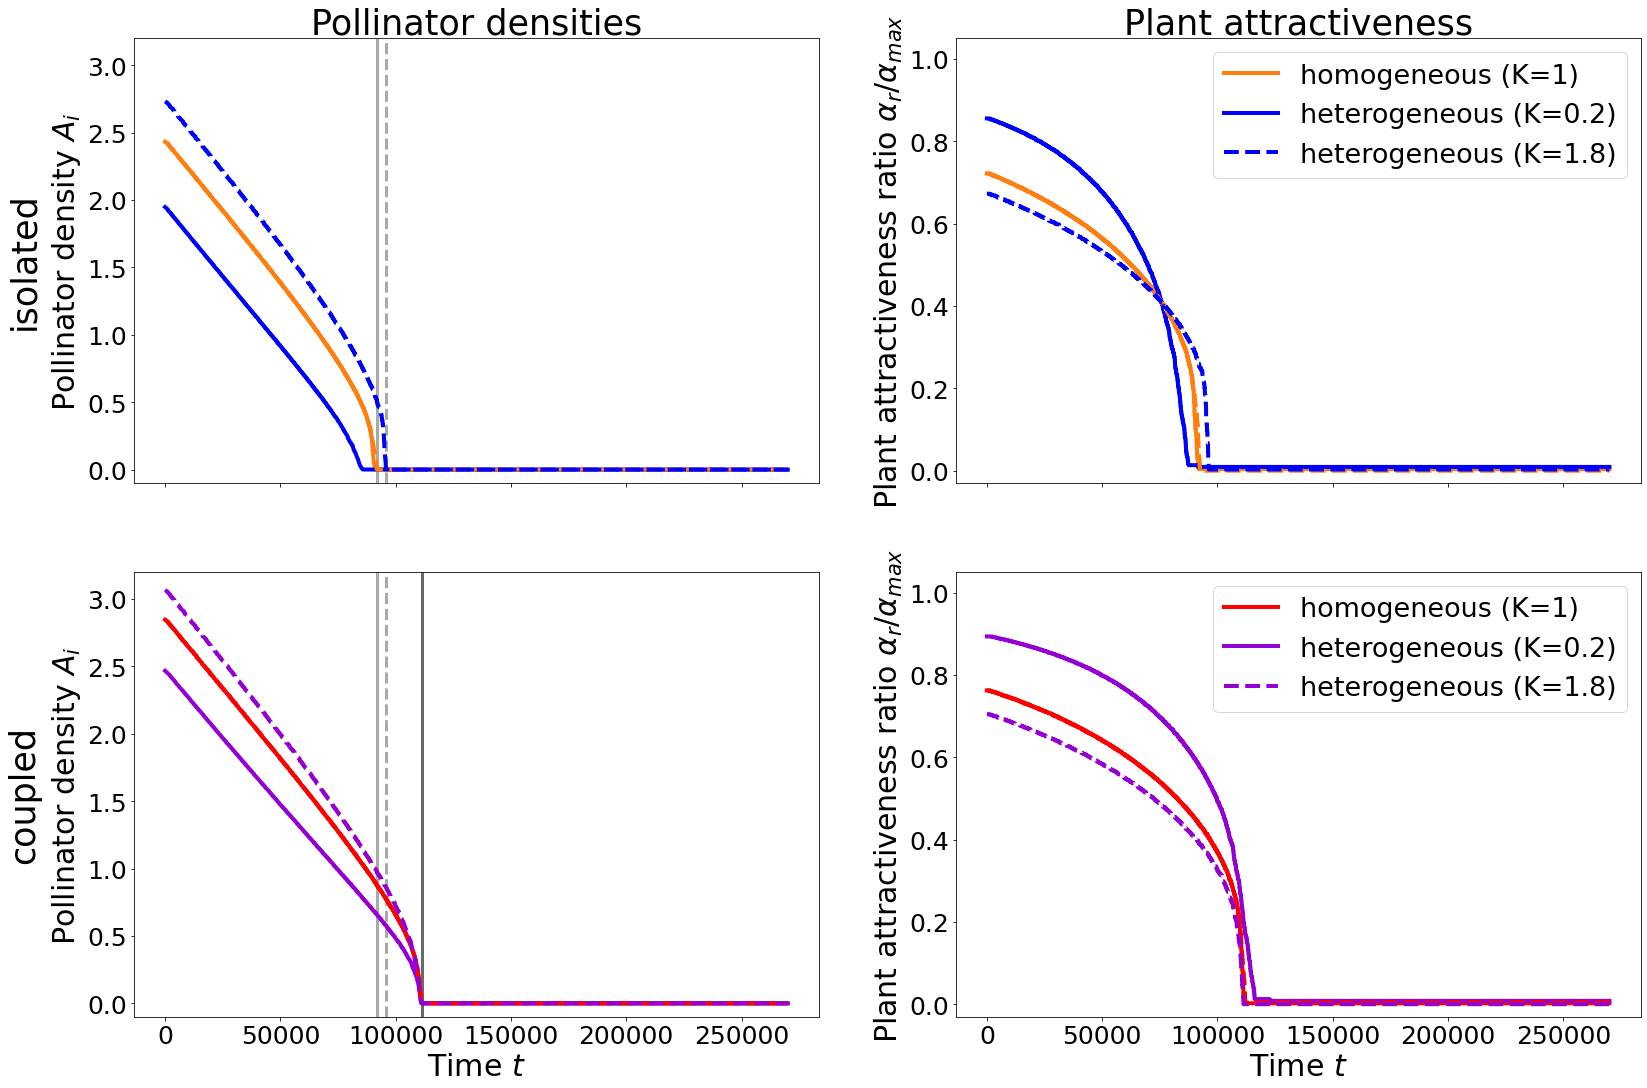

In [7]:
# code for plotting 
start=0
end=270000

linestyles = ['-', '--']

cols = ['{}'.format(col) for col in ['Pollinator densities', 'Plant attractiveness']]
rows = ['{}'.format(row) for row in ['isolated', 'coupled']]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(27,18), constrained_layout=False, sharex=True)
pad = 5 # in points

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size=35, ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=35, ha='right', va='center', rotation=90)

    
# 1st column pollinator densities
n_col=0
# 1st row isolated
n_row = 0
for i in [0,1]:
    axes[n_row, n_col].plot(t_complete[start:end],np.asarray(x_complete_0)[start:end,i*2], color='tab:orange', linestyle=linestyles[i], linewidth=4)
    axes[n_row, n_col].plot(t_complete[start:end],np.asarray(x_complete_2)[start:end,i*2], color='blue', linestyle=linestyles[i], linewidth=4)
axes[n_row, n_col].set_ylabel('Pollinator density $A_i$', size=30)
axes[n_row, n_col].set_ylim(-0.1, 3.2)
if evolution:
    axes[n_row, n_col].vlines(x=91879, ymin=-0.1, ymax=3.2, colors="darkgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=95959, ymin=-0.1, ymax=3.2, colors="darkgrey", linestyles='dashed', linewidth=3)
else:
    axes[n_row, n_col].vlines(x=203619, ymin=-0.1, ymax=3.2, colors="darkgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=243499, ymin=-0.1, ymax=3.2, colors="darkgrey", linestyles='dashed', linewidth=3)
axes[n_row, n_col].tick_params(axis='x', labelsize=25)
axes[n_row, n_col].tick_params(axis='y', labelsize=25)

# 2nd row coupled
n_row = 1
for i in [0,1]:
    axes[n_row, n_col].plot(t_complete[start:end],np.asarray(x_complete_1)[start:end,i*2], color='red', linestyle=linestyles[i], linewidth=4)
    axes[n_row, n_col].plot(t_complete[start:end],np.asarray(x_complete_3)[start:end,i*2], color='darkviolet', linestyle=linestyles[i], linewidth=4)
axes[n_row, n_col].set_xlabel('Time $t$', size=30)
axes[n_row, n_col].set_ylabel('Pollinator density $A_i$', size=30)
axes[n_row, n_col].set_ylim(-0.1, 3.2)
if evolution:
    axes[n_row, n_col].vlines(x=91879, ymin=-0.1, ymax=3.2, colors="darkgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=111379, ymin=-0.1, ymax=3.2, colors="dimgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=95959, ymin=-0.1, ymax=3.2, colors="darkgrey", linestyles='dashed', linewidth=3)
    axes[n_row, n_col].vlines(x=111279, ymin=-0.1, ymax=3.2, colors="dimgrey", linestyles='dashed', linewidth=3)
else:
    axes[n_row, n_col].vlines(x=203619, ymin=-0.1, ymax=3.2, colors="darkgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=224299, ymin=-0.1, ymax=3.2, colors="dimgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=243499, ymin=-0.1, ymax=3.2, colors="darkgrey", linestyles='dashed', linewidth=3)
    axes[n_row, n_col].vlines(x=249519, ymin=-0.1, ymax=3.2, colors="dimgrey", linestyles='dashed', linewidth=3)
axes[n_row, n_col].tick_params(axis='x', labelsize=25)
axes[n_row, n_col].tick_params(axis='y', labelsize=25)


# 2nd column plant attractivness
n_col=1
# 1st row isolated
n_row = 0
i=0
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_0, t_interval, 0))[start:end,i]/alpha_max_vals_0[i], 
                        color='tab:orange', linestyle=linestyles[i], linewidth=4, label='homogeneous (K=1)')
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_2, t_interval, 0))[start:end,i]/alpha_max_vals_2[i], 
                        color='blue', linestyle=linestyles[i], linewidth=4, label='heterogeneous (K=0.2)')
i=1
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_0, t_interval, 0))[start:end,i]/alpha_max_vals_0[i], 
                        color='tab:orange', linestyle=linestyles[i], linewidth=4)
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_2, t_interval, 0))[start:end,i]/alpha_max_vals_2[i], 
                        color='blue', linestyle=linestyles[i], linewidth=4, label='heterogeneous (K=1.8)')

axes[n_row, n_col].set_ylabel(r'Plant attractiveness ratio $\alpha_{r}/\alpha_{max}$', size=30)
axes[n_row, n_col].set_ylim(-0.03, 1.05)
axes[n_row, n_col].tick_params(axis='x', labelsize=25)
axes[n_row, n_col].tick_params(axis='y', labelsize=25)
if evolution:
    axes[n_row, n_col].legend(loc="upper right", fontsize=27)
else:
    axes[n_row, n_col].legend(loc="lower right", fontsize=27)

# 2nd row coupled
n_row = 1
i=0
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_1, t_interval, 0))[start:end,i]/alpha_max_vals_1[i], 
                            color='red', linestyle=linestyles[i], linewidth=4, label='homogeneous (K=1)')
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_3, t_interval, 0))[start:end,i]/alpha_max_vals_3[i], 
                            color='darkviolet', linestyle=linestyles[i], linewidth=4, label='heterogeneous (K=0.2)')
i=1
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_1, t_interval, 0))[start:end,i]/alpha_max_vals_1[i], 
                            color='red', linestyle=linestyles[i], linewidth=4)
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_3, t_interval, 0))[start:end,i]/alpha_max_vals_3[i], 
                            color='darkviolet', linestyle=linestyles[i], linewidth=4, label='heterogeneous (K=1.8)')
axes[n_row, n_col].set_xlabel('Time $t$', size=30)
axes[n_row, n_col].set_ylabel(r'Plant attractiveness ratio $\alpha_{r}/\alpha_{max}$', size=30)
axes[n_row, n_col].set_ylim(-0.03, 1.05)
axes[n_row, n_col].tick_params(axis='x', labelsize=25)
axes[n_row, n_col].tick_params(axis='y', labelsize=25)
if evolution:
    axes[n_row, n_col].legend(loc="upper right", fontsize=27)
else:
    axes[n_row, n_col].legend(loc="lower right", fontsize=27)

## mut_step = 0.001

In [8]:
# set ecological parameter values:
gamma_A = 0.2            # interaction benefit provided by the pollinator
gamma_P = 1              # interaction benefit provided by the pollinator
c_A = 1                  # intraspecific competition strength of the pollinator 
s = 2.5                  # trade-off shape form factor

# dispersal rate
d = 0.2

# initial pollinator growth rate
r_Aorig = 0.6            # for comparison with non-spatial model
r_A0 = r_Aorig + d

# parameter for environmental change
r_A_change = -0.000008   # change of r_A per time step

# parameters for evolution
t_interval = 20           # length of time interval between mutations
t_step = 1                # one data point per time step
mut_step = 0.001           # maximum mutation step size

# extinction threshold
A_ext = 0.0001

### Simulations:

The extinction times are printed below in the order: isolated homogeneous, coupled homogeneous, isolated heterogeneous, coupled heterogeneous.

In [9]:
t_end = 300000
environmental_change = True
#evolution = False


c_P_vals_list = [np.array([1, 1]), np.array([1, 1]), np.array([5, 1/1.8]), np.array([5, 1/1.8])]   
delta_max_list = [0.0, 1.0, 0.0, 1.0]

for count in range(4):
    
    printed = False

    delta_max = delta_max_list[count]
    c_P_vals = c_P_vals_list[count]

    ########################### migration matrix
    success = fct_rgg.linkwise_success(delta, delta_max)

    # calculate migration frations
    fractions = fct_rgg.fractions_ij(success)

    # calculate combined miration matrix
    mig_matrix = success * fractions

    ############################# initialisation
    # population initialisation
    x0_ini, alpha_max_vals, alpha_r_vals_ini, alpha_m_vals_ini = fct_rgg.initialisation(c_P_vals, c_A, gamma_P, gamma_A, 
                                                                    s, d, r_A0, r_A_change, N, mig_matrix, 0.02)
    seeding = 1000


    '''############################ simulations ##############################'''
    # prepare empty lists to store simulation results for extinction checks

    #for evolution in [True, False]:
    x_complete = []
    t_complete = []
    f_complete = []
    r_A_vals = []
    alpha_r_complete = []
    order_of_extinction = np.zeros(N)
    
    x0 = x0_ini
    alpha_r_vals = alpha_r_vals_ini
    alpha_m_vals = alpha_m_vals_ini

    # set seed
    rd.seed(seeding)
                
    for i in range (int(t_end / t_interval)):       # loop through the time intervals

        # calculate per-capita growth rates from alpha
        r_P_r_vals = fct_rgg.r_P_function(alpha_r_vals, alpha_max_vals, s)
        r_P_m_vals = fct_rgg.r_P_function(alpha_m_vals, alpha_max_vals, s)

        # t-values for the current time interval, that is between pertubation i and pertubation i+1:
        t = np.arange(0,t_interval,t_step) + i*t_interval

        # additional parameters to give into the odeint-function
        env_params = [r_A0, r_A_change, environmental_change]
        plant_params = [alpha_r_vals, r_P_r_vals]
        migration_params =  [d, mig_matrix]

        # time series
        x = integ.odeint(fct_rgg.metacommunity,x0,t, 
                        args=(env_params, c_A, c_P_vals, gamma_A, gamma_P, plant_params, migration_params, N))

        # calculate and save overall migration success
        f = fct_rgg.overall_migration_success(x, d, mig_matrix, N)
        f = np.repeat(f, t_interval)
        f_complete.extend(f)


        # check for pollinator extinction:
        x[-1] = np.where(x[-1] < A_ext, 0, x[-1]) # when below extinction threshold send to 0

        extinct = np.array(x[-1,::2] < A_ext) # one value per pollinator population: False = alive, True = extinct
        if np.all(extinct): # when all local populations are extinct save the time
            t_extinct = t[-1]
            
            if printed == False:
                print(t_extinct)
                printed = True
        
    
        # environmental change for evolution
        if environmental_change:
            r_A = r_A0 + t * r_A_change  
        else:
            r_A = r_A0 + t * 0
        
        r_A_vals.extend(r_A)

        # save attractivity values of the current resident populations
        alpha_r_complete.append(alpha_r_vals)

        # perform evolution if activated
        if evolution:
            alpha_r_vals, alpha_m_vals = fct_rgg.evolution_function(alpha_r_vals, alpha_m_vals, 
                                                                r_P_r_vals, r_P_m_vals, 
                                                                c_P_vals, r_A[-1], 
                                                                c_A, gamma_P, gamma_A, s, 
                                                                mut_step, d, x[-1])

        # save densities
        x0 = x[-1]    
        x_complete.extend(x)
        t_complete.extend(t)


    if count == 0:
        x_complete_0 = x_complete
        alpha_r_complete_0 = alpha_r_complete
        f_complete_0 = f_complete
        alpha_max_vals_0 = alpha_max_vals
    
    if count == 1:
        x_complete_1 = x_complete
        alpha_r_complete_1 = alpha_r_complete
        f_complete_1 = f_complete
        alpha_max_vals_1 = alpha_max_vals
        
    if count == 2:
        x_complete_2 = x_complete
        alpha_r_complete_2 = alpha_r_complete
        f_complete_2 = f_complete
        alpha_max_vals_2 = alpha_max_vals
        
    if count == 3:
        x_complete_3 = x_complete
        alpha_r_complete_3 = alpha_r_complete
        f_complete_3 = f_complete
        alpha_max_vals_3 = alpha_max_vals

130539
149479
129799
144259


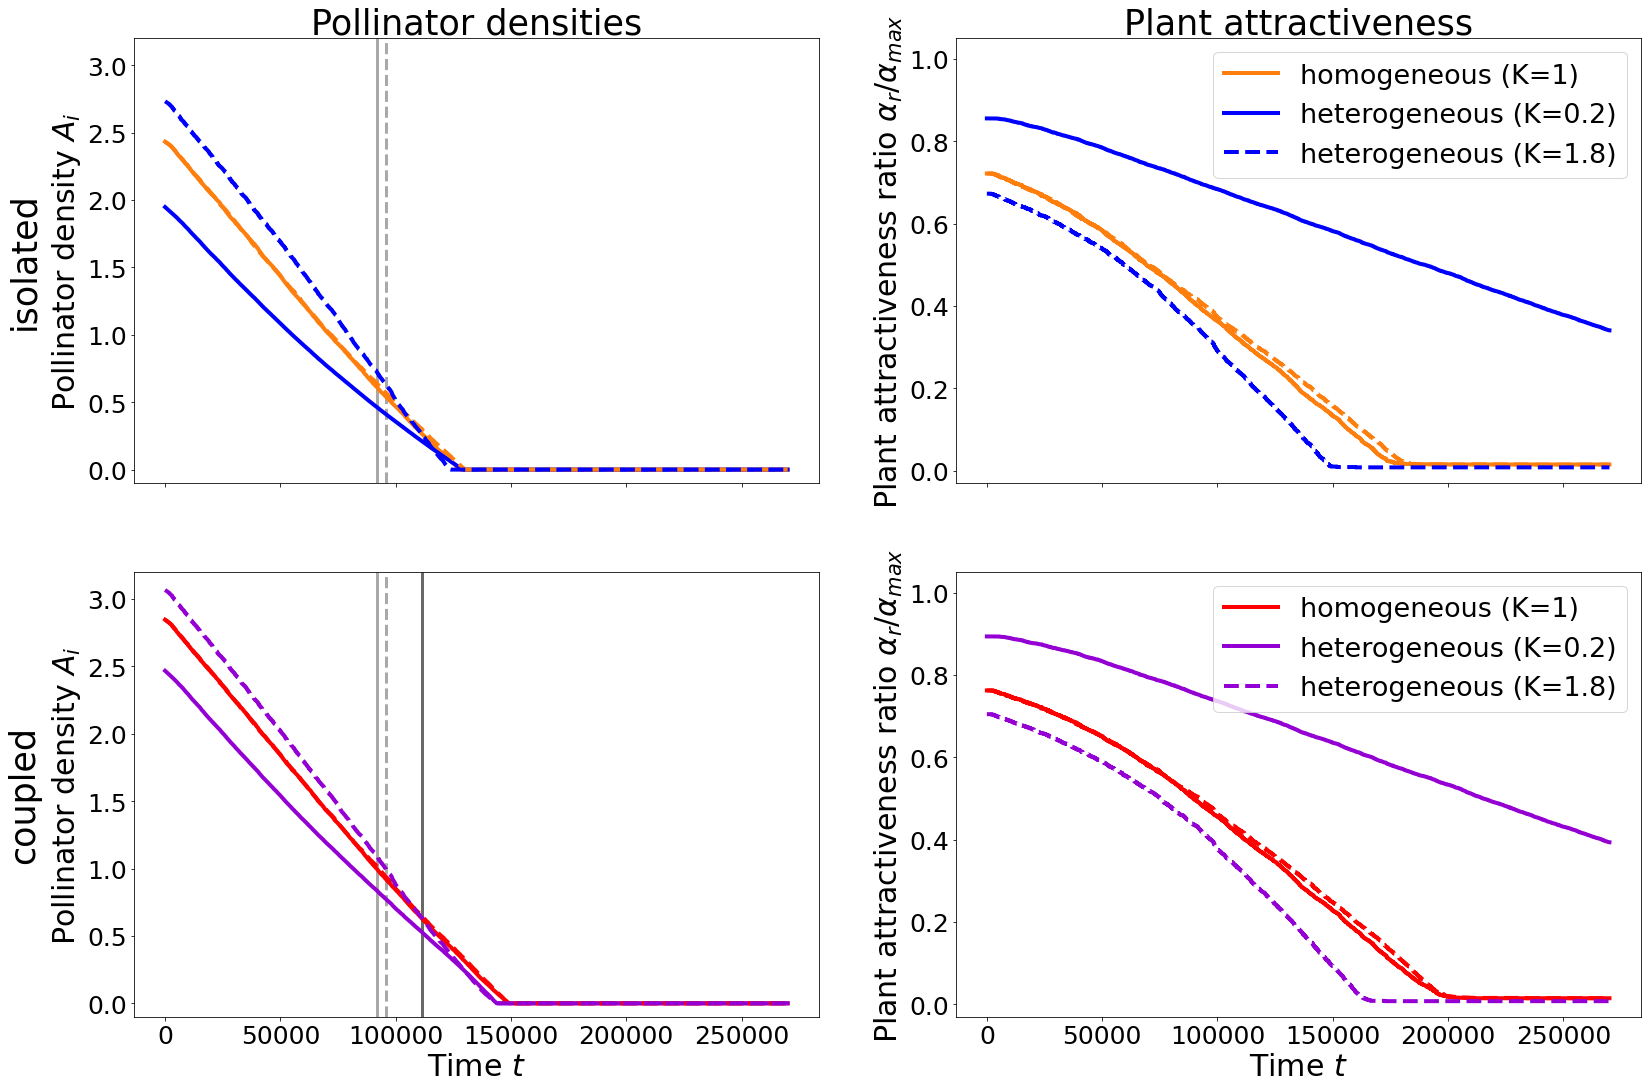

In [10]:
# code for plotting 
start=0
end=270000

linestyles = ['-', '--']

cols = ['{}'.format(col) for col in ['Pollinator densities', 'Plant attractiveness']]
rows = ['{}'.format(row) for row in ['isolated', 'coupled']]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(27,18), constrained_layout=False, sharex=True)
pad = 5 # in points

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size=35, ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=35, ha='right', va='center', rotation=90)

    
# 1st column pollinator densities
n_col=0
# 1st row isolated
n_row = 0
for i in [0,1]:
    axes[n_row, n_col].plot(t_complete[start:end],np.asarray(x_complete_0)[start:end,i*2], color='tab:orange', linestyle=linestyles[i], linewidth=4)
    axes[n_row, n_col].plot(t_complete[start:end],np.asarray(x_complete_2)[start:end,i*2], color='blue', linestyle=linestyles[i], linewidth=4)
axes[n_row, n_col].set_ylabel('Pollinator density $A_i$', size=30)
axes[n_row, n_col].set_ylim(-0.1, 3.2)
if evolution:
    axes[n_row, n_col].vlines(x=91879, ymin=-0.1, ymax=3.2, colors="darkgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=95959, ymin=-0.1, ymax=3.2, colors="darkgrey", linestyles='dashed', linewidth=3)
else:
    axes[n_row, n_col].vlines(x=203619, ymin=-0.1, ymax=3.2, colors="darkgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=243499, ymin=-0.1, ymax=3.2, colors="darkgrey", linestyles='dashed', linewidth=3)
axes[n_row, n_col].tick_params(axis='x', labelsize=25)
axes[n_row, n_col].tick_params(axis='y', labelsize=25)

# 2nd row coupled
n_row = 1
for i in [0,1]:
    axes[n_row, n_col].plot(t_complete[start:end],np.asarray(x_complete_1)[start:end,i*2], color='red', linestyle=linestyles[i], linewidth=4)
    axes[n_row, n_col].plot(t_complete[start:end],np.asarray(x_complete_3)[start:end,i*2], color='darkviolet', linestyle=linestyles[i], linewidth=4)
axes[n_row, n_col].set_xlabel('Time $t$', size=30)
axes[n_row, n_col].set_ylabel('Pollinator density $A_i$', size=30)
axes[n_row, n_col].set_ylim(-0.1, 3.2)
if evolution:
    axes[n_row, n_col].vlines(x=91879, ymin=-0.1, ymax=3.2, colors="darkgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=111379, ymin=-0.1, ymax=3.2, colors="dimgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=95959, ymin=-0.1, ymax=3.2, colors="darkgrey", linestyles='dashed', linewidth=3)
    axes[n_row, n_col].vlines(x=111279, ymin=-0.1, ymax=3.2, colors="dimgrey", linestyles='dashed', linewidth=3)
else:
    axes[n_row, n_col].vlines(x=203619, ymin=-0.1, ymax=3.2, colors="darkgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=224299, ymin=-0.1, ymax=3.2, colors="dimgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=243499, ymin=-0.1, ymax=3.2, colors="darkgrey", linestyles='dashed', linewidth=3)
    axes[n_row, n_col].vlines(x=249519, ymin=-0.1, ymax=3.2, colors="dimgrey", linestyles='dashed', linewidth=3)
axes[n_row, n_col].tick_params(axis='x', labelsize=25)
axes[n_row, n_col].tick_params(axis='y', labelsize=25)


# 2nd column plant attractivness
n_col=1
# 1st row isolated
n_row = 0
i=0
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_0, t_interval, 0))[start:end,i]/alpha_max_vals_0[i], 
                        color='tab:orange', linestyle=linestyles[i], linewidth=4, label='homogeneous (K=1)')
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_2, t_interval, 0))[start:end,i]/alpha_max_vals_2[i], 
                        color='blue', linestyle=linestyles[i], linewidth=4, label='heterogeneous (K=0.2)')
i=1
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_0, t_interval, 0))[start:end,i]/alpha_max_vals_0[i], 
                        color='tab:orange', linestyle=linestyles[i], linewidth=4)
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_2, t_interval, 0))[start:end,i]/alpha_max_vals_2[i], 
                        color='blue', linestyle=linestyles[i], linewidth=4, label='heterogeneous (K=1.8)')

axes[n_row, n_col].set_ylabel(r'Plant attractiveness ratio $\alpha_{r}/\alpha_{max}$', size=30)
axes[n_row, n_col].set_ylim(-0.03, 1.05)
axes[n_row, n_col].tick_params(axis='x', labelsize=25)
axes[n_row, n_col].tick_params(axis='y', labelsize=25)
if evolution:
    axes[n_row, n_col].legend(loc="upper right", fontsize=27)
else:
    axes[n_row, n_col].legend(loc="lower right", fontsize=27)

# 2nd row coupled
n_row = 1
i=0
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_1, t_interval, 0))[start:end,i]/alpha_max_vals_1[i], 
                            color='red', linestyle=linestyles[i], linewidth=4, label='homogeneous (K=1)')
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_3, t_interval, 0))[start:end,i]/alpha_max_vals_3[i], 
                            color='darkviolet', linestyle=linestyles[i], linewidth=4, label='heterogeneous (K=0.2)')
i=1
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_1, t_interval, 0))[start:end,i]/alpha_max_vals_1[i], 
                            color='red', linestyle=linestyles[i], linewidth=4)
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_3, t_interval, 0))[start:end,i]/alpha_max_vals_3[i], 
                            color='darkviolet', linestyle=linestyles[i], linewidth=4, label='heterogeneous (K=1.8)')
axes[n_row, n_col].set_xlabel('Time $t$', size=30)
axes[n_row, n_col].set_ylabel(r'Plant attractiveness ratio $\alpha_{r}/\alpha_{max}$', size=30)
axes[n_row, n_col].set_ylim(-0.03, 1.05)
axes[n_row, n_col].tick_params(axis='x', labelsize=25)
axes[n_row, n_col].tick_params(axis='y', labelsize=25)
if evolution:
    axes[n_row, n_col].legend(loc="upper right", fontsize=27)
else:
    axes[n_row, n_col].legend(loc="lower right", fontsize=27)

## s = 3.5

In [11]:
# set ecological parameter values:
gamma_A = 0.2            # interaction benefit provided by the pollinator
gamma_P = 1              # interaction benefit provided by the pollinator
c_A = 1                  # intraspecific competition strength of the pollinator 
s = 3.5                  # trade-off shape form factor

# dispersal rate
d = 0.2

# initial pollinator growth rate
r_Aorig = 0.6            # for comparison with non-spatial model
r_A0 = r_Aorig + d

# parameter for environmental change
r_A_change = -0.000008   # change of r_A per time step

# parameters for evolution
t_interval = 20           # length of time interval between mutations
t_step = 1                # one data point per time step
mut_step = 0.02           # maximum mutation step size

# extinction threshold
A_ext = 0.0001

### Simulations:

The extinction times are printed below in the order: isolated homogeneous, coupled homogeneous, isolated heterogeneous, coupled heterogeneous.

In [12]:
t_end = 300000
environmental_change = True
#evolution = False


c_P_vals_list = [np.array([1, 1]), np.array([1, 1]), np.array([5, 1/1.8]), np.array([5, 1/1.8])]   
delta_max_list = [0.0, 1.0, 0.0, 1.0]

for count in range(4):
    
    printed = False

    delta_max = delta_max_list[count]
    c_P_vals = c_P_vals_list[count]

    ########################### migration matrix
    success = fct_rgg.linkwise_success(delta, delta_max)

    # calculate migration frations
    fractions = fct_rgg.fractions_ij(success)

    # calculate combined miration matrix
    mig_matrix = success * fractions

    ############################# initialisation
    # population initialisation
    x0_ini, alpha_max_vals, alpha_r_vals_ini, alpha_m_vals_ini = fct_rgg.initialisation(c_P_vals, c_A, gamma_P, gamma_A, 
                                                                    s, d, r_A0, r_A_change, N, mig_matrix, 0.02)
    seeding = 1000


    '''############################ simulations ##############################'''
    # prepare empty lists to store simulation results for extinction checks

    #for evolution in [True, False]:
    x_complete = []
    t_complete = []
    f_complete = []
    r_A_vals = []
    alpha_r_complete = []
    order_of_extinction = np.zeros(N)
    
    x0 = x0_ini
    alpha_r_vals = alpha_r_vals_ini
    alpha_m_vals = alpha_m_vals_ini

    # set seed
    rd.seed(seeding)
                
    for i in range (int(t_end / t_interval)):       # loop through the time intervals

        # calculate per-capita growth rates from alpha
        r_P_r_vals = fct_rgg.r_P_function(alpha_r_vals, alpha_max_vals, s)
        r_P_m_vals = fct_rgg.r_P_function(alpha_m_vals, alpha_max_vals, s)

        # t-values for the current time interval, that is between pertubation i and pertubation i+1:
        t = np.arange(0,t_interval,t_step) + i*t_interval

        # additional parameters to give into the odeint-function
        env_params = [r_A0, r_A_change, environmental_change]
        plant_params = [alpha_r_vals, r_P_r_vals]
        migration_params =  [d, mig_matrix]

        # time series
        x = integ.odeint(fct_rgg.metacommunity,x0,t, 
                        args=(env_params, c_A, c_P_vals, gamma_A, gamma_P, plant_params, migration_params, N))

        # calculate and save overall migration success
        f = fct_rgg.overall_migration_success(x, d, mig_matrix, N)
        f = np.repeat(f, t_interval)
        f_complete.extend(f)


        # check for pollinator extinction:
        x[-1] = np.where(x[-1] < A_ext, 0, x[-1]) # when below extinction threshold send to 0

        extinct = np.array(x[-1,::2] < A_ext) # one value per pollinator population: False = alive, True = extinct
        if np.all(extinct): # when all local populations are extinct save the time
            t_extinct = t[-1]
            
            if printed == False:
                print(t_extinct)
                printed = True
        
    
        # environmental change for evolution
        if environmental_change:
            r_A = r_A0 + t * r_A_change  
        else:
            r_A = r_A0 + t * 0
        
        r_A_vals.extend(r_A)

        # save attractivity values of the current resident populations
        alpha_r_complete.append(alpha_r_vals)

        # perform evolution if activated
        if evolution:
            alpha_r_vals, alpha_m_vals = fct_rgg.evolution_function(alpha_r_vals, alpha_m_vals, 
                                                                r_P_r_vals, r_P_m_vals, 
                                                                c_P_vals, r_A[-1], 
                                                                c_A, gamma_P, gamma_A, s, 
                                                                mut_step, d, x[-1])

        # save densities
        x0 = x[-1]    
        x_complete.extend(x)
        t_complete.extend(t)


    if count == 0:
        x_complete_0 = x_complete
        alpha_r_complete_0 = alpha_r_complete
        f_complete_0 = f_complete
        alpha_max_vals_0 = alpha_max_vals
    
    if count == 1:
        x_complete_1 = x_complete
        alpha_r_complete_1 = alpha_r_complete
        f_complete_1 = f_complete
        alpha_max_vals_1 = alpha_max_vals
        
    if count == 2:
        x_complete_2 = x_complete
        alpha_r_complete_2 = alpha_r_complete
        f_complete_2 = f_complete
        alpha_max_vals_2 = alpha_max_vals
        
    if count == 3:
        x_complete_3 = x_complete
        alpha_r_complete_3 = alpha_r_complete
        f_complete_3 = f_complete
        alpha_max_vals_3 = alpha_max_vals

133639
153779
152739
159859


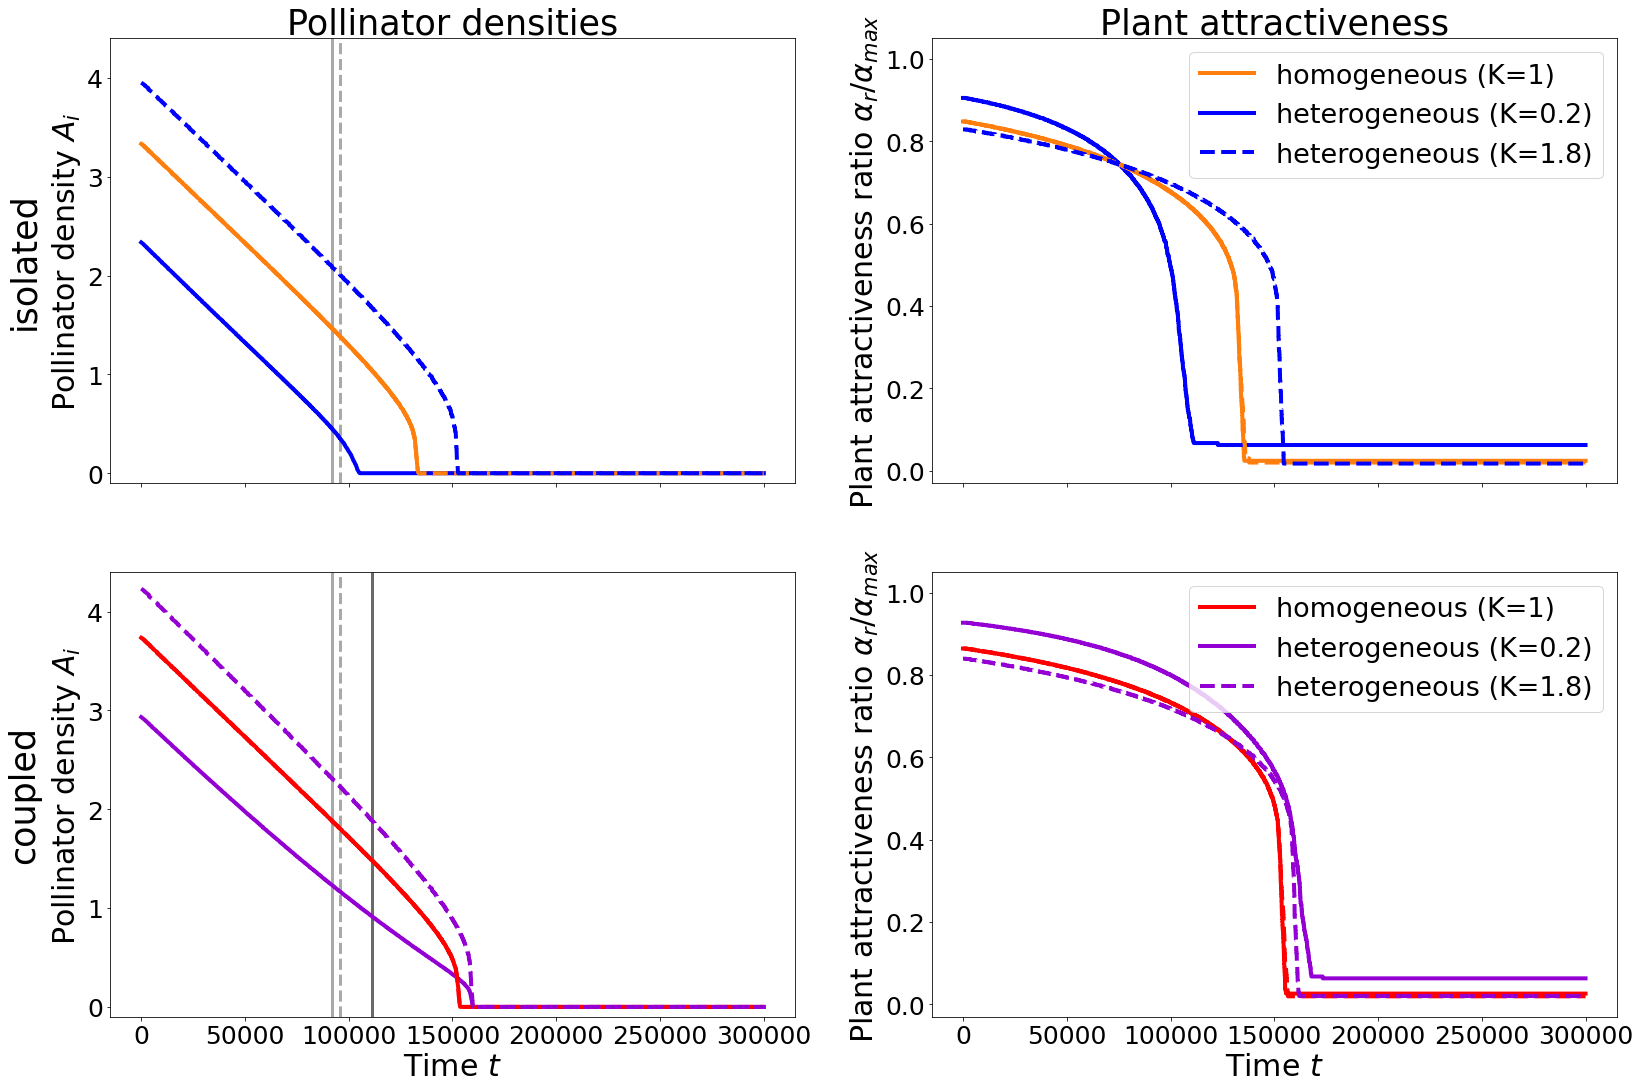

In [13]:
# code for plotting 
start=0
end=300000

linestyles = ['-', '--']

cols = ['{}'.format(col) for col in ['Pollinator densities', 'Plant attractiveness']]
rows = ['{}'.format(row) for row in ['isolated', 'coupled']]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(27,18), constrained_layout=False, sharex=True)
pad = 5 # in points

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size=35, ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=35, ha='right', va='center', rotation=90)

    
# 1st column pollinator densities
n_col=0
# 1st row isolated
n_row = 0
for i in [0,1]:
    axes[n_row, n_col].plot(t_complete[start:end],np.asarray(x_complete_0)[start:end,i*2], color='tab:orange', linestyle=linestyles[i], linewidth=4)
    axes[n_row, n_col].plot(t_complete[start:end],np.asarray(x_complete_2)[start:end,i*2], color='blue', linestyle=linestyles[i], linewidth=4)
axes[n_row, n_col].set_ylabel('Pollinator density $A_i$', size=30)
axes[n_row, n_col].set_ylim(-0.1, 4.4)
if evolution:
    axes[n_row, n_col].vlines(x=91879, ymin=-0.1, ymax=4.4, colors="darkgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=95959, ymin=-0.1, ymax=4.4, colors="darkgrey", linestyles='dashed', linewidth=3)
else:
    axes[n_row, n_col].vlines(x=203619, ymin=-0.1, ymax=4.4, colors="darkgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=243499, ymin=-0.1, ymax=4.4, colors="darkgrey", linestyles='dashed', linewidth=3)
axes[n_row, n_col].tick_params(axis='x', labelsize=25)
axes[n_row, n_col].tick_params(axis='y', labelsize=25)

# 2nd row coupled
n_row = 1
for i in [0,1]:
    axes[n_row, n_col].plot(t_complete[start:end],np.asarray(x_complete_1)[start:end,i*2], color='red', linestyle=linestyles[i], linewidth=4)
    axes[n_row, n_col].plot(t_complete[start:end],np.asarray(x_complete_3)[start:end,i*2], color='darkviolet', linestyle=linestyles[i], linewidth=4)
axes[n_row, n_col].set_xlabel('Time $t$', size=30)
axes[n_row, n_col].set_ylabel('Pollinator density $A_i$', size=30)
axes[n_row, n_col].set_ylim(-0.1, 4.4)
if evolution:
    axes[n_row, n_col].vlines(x=91879, ymin=-0.1, ymax=4.4, colors="darkgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=111379, ymin=-0.1, ymax=4.4, colors="dimgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=95959, ymin=-0.1, ymax=4.4, colors="darkgrey", linestyles='dashed', linewidth=3)
    axes[n_row, n_col].vlines(x=111279, ymin=-0.1, ymax=4.4, colors="dimgrey", linestyles='dashed', linewidth=3)
else:
    axes[n_row, n_col].vlines(x=203619, ymin=-0.1, ymax=4.4, colors="darkgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=224299, ymin=-0.1, ymax=4.4, colors="dimgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=243499, ymin=-0.1, ymax=4.4, colors="darkgrey", linestyles='dashed', linewidth=3)
    axes[n_row, n_col].vlines(x=249519, ymin=-0.1, ymax=4.4, colors="dimgrey", linestyles='dashed', linewidth=3)
axes[n_row, n_col].tick_params(axis='x', labelsize=25)
axes[n_row, n_col].tick_params(axis='y', labelsize=25)


# 2nd column plant attractivness
n_col=1
# 1st row isolated
n_row = 0
i=0
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_0, t_interval, 0))[start:end,i]/alpha_max_vals_0[i], 
                        color='tab:orange', linestyle=linestyles[i], linewidth=4, label='homogeneous (K=1)')
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_2, t_interval, 0))[start:end,i]/alpha_max_vals_2[i], 
                        color='blue', linestyle=linestyles[i], linewidth=4, label='heterogeneous (K=0.2)')
i=1
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_0, t_interval, 0))[start:end,i]/alpha_max_vals_0[i], 
                        color='tab:orange', linestyle=linestyles[i], linewidth=4)
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_2, t_interval, 0))[start:end,i]/alpha_max_vals_2[i], 
                        color='blue', linestyle=linestyles[i], linewidth=4, label='heterogeneous (K=1.8)')

axes[n_row, n_col].set_ylabel(r'Plant attractiveness ratio $\alpha_{r}/\alpha_{max}$', size=30)
axes[n_row, n_col].set_ylim(-0.03, 1.05)
axes[n_row, n_col].tick_params(axis='x', labelsize=25)
axes[n_row, n_col].tick_params(axis='y', labelsize=25)
if evolution:
    axes[n_row, n_col].legend(loc="upper right", fontsize=27)
else:
    axes[n_row, n_col].legend(loc="lower right", fontsize=27)

# 2nd row coupled
n_row = 1
i=0
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_1, t_interval, 0))[start:end,i]/alpha_max_vals_1[i], 
                            color='red', linestyle=linestyles[i], linewidth=4, label='homogeneous (K=1)')
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_3, t_interval, 0))[start:end,i]/alpha_max_vals_3[i], 
                            color='darkviolet', linestyle=linestyles[i], linewidth=4, label='heterogeneous (K=0.2)')
i=1
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_1, t_interval, 0))[start:end,i]/alpha_max_vals_1[i], 
                            color='red', linestyle=linestyles[i], linewidth=4)
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_3, t_interval, 0))[start:end,i]/alpha_max_vals_3[i], 
                            color='darkviolet', linestyle=linestyles[i], linewidth=4, label='heterogeneous (K=1.8)')
axes[n_row, n_col].set_xlabel('Time $t$', size=30)
axes[n_row, n_col].set_ylabel(r'Plant attractiveness ratio $\alpha_{r}/\alpha_{max}$', size=30)
axes[n_row, n_col].set_ylim(-0.03, 1.05)
axes[n_row, n_col].tick_params(axis='x', labelsize=25)
axes[n_row, n_col].tick_params(axis='y', labelsize=25)
if evolution:
    axes[n_row, n_col].legend(loc="upper right", fontsize=27)
else:
    axes[n_row, n_col].legend(loc="lower right", fontsize=27)

## d = 0.5

In [14]:
# set ecological parameter values:
gamma_A = 0.2            # interaction benefit provided by the pollinator
gamma_P = 1              # interaction benefit provided by the pollinator
c_A = 1                  # intraspecific competition strength of the pollinator 
s = 2.5                  # trade-off shape form factor

# dispersal rate
d = 0.5

# initial pollinator growth rate
r_Aorig = 0.6            # for comparison with non-spatial model
r_A0 = r_Aorig + d

# parameter for environmental change
r_A_change = -0.000008   # change of r_A per time step

# parameters for evolution
t_interval = 20           # length of time interval between mutations
t_step = 1                # one data point per time step
mut_step = 0.02           # maximum mutation step size

# extinction threshold
A_ext = 0.0001

### Simulations:

The extinction times are printed below in the order: isolated homogeneous, coupled homogeneous, isolated heterogeneous, coupled heterogeneous.

In [15]:
t_end = 300000
environmental_change = True
#evolution = False


c_P_vals_list = [np.array([1, 1]), np.array([1, 1]), np.array([5, 1/1.8]), np.array([5, 1/1.8])]   
delta_max_list = [0.0, 1.0, 0.0, 1.0]

for count in range(4):
    
    printed = False

    delta_max = delta_max_list[count]
    c_P_vals = c_P_vals_list[count]

    ########################### migration matrix
    success = fct_rgg.linkwise_success(delta, delta_max)

    # calculate migration frations
    fractions = fct_rgg.fractions_ij(success)

    # calculate combined miration matrix
    mig_matrix = success * fractions

    ############################# initialisation
    # population initialisation
    x0_ini, alpha_max_vals, alpha_r_vals_ini, alpha_m_vals_ini = fct_rgg.initialisation(c_P_vals, c_A, gamma_P, gamma_A, 
                                                                    s, d, r_A0, r_A_change, N, mig_matrix, 0.02)
    seeding = 1000


    '''############################ simulations ##############################'''
    # prepare empty lists to store simulation results for extinction checks

    #for evolution in [True, False]:
    x_complete = []
    t_complete = []
    f_complete = []
    r_A_vals = []
    alpha_r_complete = []
    order_of_extinction = np.zeros(N)
    
    x0 = x0_ini
    alpha_r_vals = alpha_r_vals_ini
    alpha_m_vals = alpha_m_vals_ini

    # set seed
    rd.seed(seeding)
                
    for i in range (int(t_end / t_interval)):       # loop through the time intervals

        # calculate per-capita growth rates from alpha
        r_P_r_vals = fct_rgg.r_P_function(alpha_r_vals, alpha_max_vals, s)
        r_P_m_vals = fct_rgg.r_P_function(alpha_m_vals, alpha_max_vals, s)

        # t-values for the current time interval, that is between pertubation i and pertubation i+1:
        t = np.arange(0,t_interval,t_step) + i*t_interval

        # additional parameters to give into the odeint-function
        env_params = [r_A0, r_A_change, environmental_change]
        plant_params = [alpha_r_vals, r_P_r_vals]
        migration_params =  [d, mig_matrix]

        # time series
        x = integ.odeint(fct_rgg.metacommunity,x0,t, 
                        args=(env_params, c_A, c_P_vals, gamma_A, gamma_P, plant_params, migration_params, N))

        # calculate and save overall migration success
        f = fct_rgg.overall_migration_success(x, d, mig_matrix, N)
        f = np.repeat(f, t_interval)
        f_complete.extend(f)


        # check for pollinator extinction:
        x[-1] = np.where(x[-1] < A_ext, 0, x[-1]) # when below extinction threshold send to 0

        extinct = np.array(x[-1,::2] < A_ext) # one value per pollinator population: False = alive, True = extinct
        if np.all(extinct): # when all local populations are extinct save the time
            t_extinct = t[-1]
            
            if printed == False:
                print(t_extinct)
                printed = True
        
    
        # environmental change for evolution
        if environmental_change:
            r_A = r_A0 + t * r_A_change  
        else:
            r_A = r_A0 + t * 0
        
        r_A_vals.extend(r_A)

        # save attractivity values of the current resident populations
        alpha_r_complete.append(alpha_r_vals)

        # perform evolution if activated
        if evolution:
            alpha_r_vals, alpha_m_vals = fct_rgg.evolution_function(alpha_r_vals, alpha_m_vals, 
                                                                r_P_r_vals, r_P_m_vals, 
                                                                c_P_vals, r_A[-1], 
                                                                c_A, gamma_P, gamma_A, s, 
                                                                mut_step, d, x[-1])

        # save densities
        x0 = x[-1]    
        x_complete.extend(x)
        t_complete.extend(t)


    if count == 0:
        x_complete_0 = x_complete
        alpha_r_complete_0 = alpha_r_complete
        f_complete_0 = f_complete
        alpha_max_vals_0 = alpha_max_vals
    
    if count == 1:
        x_complete_1 = x_complete
        alpha_r_complete_1 = alpha_r_complete
        f_complete_1 = f_complete
        alpha_max_vals_1 = alpha_max_vals
        
    if count == 2:
        x_complete_2 = x_complete
        alpha_r_complete_2 = alpha_r_complete
        f_complete_2 = f_complete
        alpha_max_vals_2 = alpha_max_vals
        
    if count == 3:
        x_complete_3 = x_complete
        alpha_r_complete_3 = alpha_r_complete
        f_complete_3 = f_complete
        alpha_max_vals_3 = alpha_max_vals

91879
141639
95959
140819


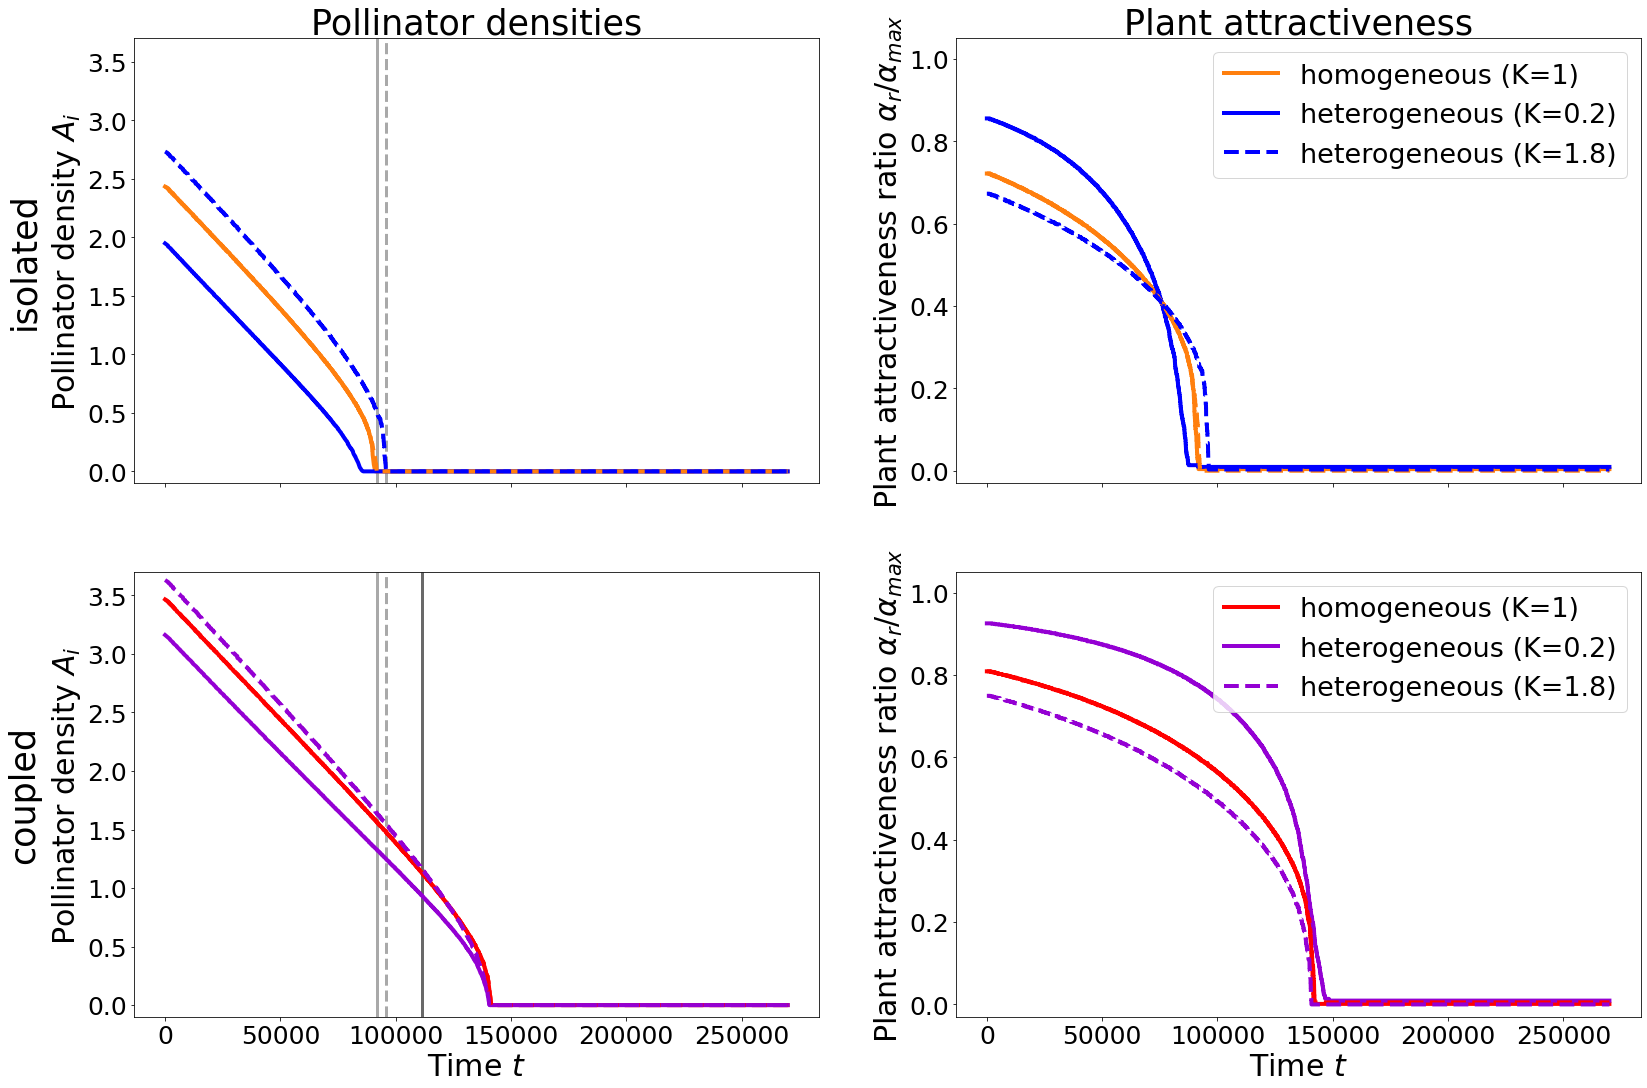

In [16]:
# code for plotting 
start=0
end=270000

linestyles = ['-', '--']

cols = ['{}'.format(col) for col in ['Pollinator densities', 'Plant attractiveness']]
rows = ['{}'.format(row) for row in ['isolated', 'coupled']]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(27,18), constrained_layout=False, sharex=True)
pad = 5 # in points

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size=35, ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=35, ha='right', va='center', rotation=90)

    
# 1st column pollinator densities
n_col=0
# 1st row isolated
n_row = 0
for i in [0,1]:
    axes[n_row, n_col].plot(t_complete[start:end],np.asarray(x_complete_0)[start:end,i*2], color='tab:orange', linestyle=linestyles[i], linewidth=4)
    axes[n_row, n_col].plot(t_complete[start:end],np.asarray(x_complete_2)[start:end,i*2], color='blue', linestyle=linestyles[i], linewidth=4)
axes[n_row, n_col].set_ylabel('Pollinator density $A_i$', size=30)
axes[n_row, n_col].set_ylim(-0.1, 3.7) #3.2)
if evolution:
    axes[n_row, n_col].vlines(x=91879, ymin=-0.1, ymax=3.7, colors="darkgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=95959, ymin=-0.1, ymax=3.7, colors="darkgrey", linestyles='dashed', linewidth=3)
else:
    axes[n_row, n_col].vlines(x=203619, ymin=-0.1, ymax=3.7, colors="darkgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=243499, ymin=-0.1, ymax=3.7, colors="darkgrey", linestyles='dashed', linewidth=3)
axes[n_row, n_col].tick_params(axis='x', labelsize=25)
axes[n_row, n_col].tick_params(axis='y', labelsize=25)

# 2nd row coupled
n_row = 1
for i in [0,1]:
    axes[n_row, n_col].plot(t_complete[start:end],np.asarray(x_complete_1)[start:end,i*2], color='red', linestyle=linestyles[i], linewidth=4)
    axes[n_row, n_col].plot(t_complete[start:end],np.asarray(x_complete_3)[start:end,i*2], color='darkviolet', linestyle=linestyles[i], linewidth=4)
axes[n_row, n_col].set_xlabel('Time $t$', size=30)
axes[n_row, n_col].set_ylabel('Pollinator density $A_i$', size=30)
axes[n_row, n_col].set_ylim(-0.1, 3.7) #3.2)
if evolution:
    axes[n_row, n_col].vlines(x=91879, ymin=-0.1, ymax=3.7, colors="darkgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=111379, ymin=-0.1, ymax=3.7, colors="dimgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=95959, ymin=-0.1, ymax=3.7, colors="darkgrey", linestyles='dashed', linewidth=3)
    axes[n_row, n_col].vlines(x=111279, ymin=-0.1, ymax=3.7, colors="dimgrey", linestyles='dashed', linewidth=3)
else:
    axes[n_row, n_col].vlines(x=203619, ymin=-0.1, ymax=3.7, colors="darkgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=224299, ymin=-0.1, ymax=3.7, colors="dimgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=243499, ymin=-0.1, ymax=3.7, colors="darkgrey", linestyles='dashed', linewidth=3)
    axes[n_row, n_col].vlines(x=249519, ymin=-0.1, ymax=3.7, colors="dimgrey", linestyles='dashed', linewidth=3)
axes[n_row, n_col].tick_params(axis='x', labelsize=25)
axes[n_row, n_col].tick_params(axis='y', labelsize=25)


# 2nd column plant attractivness
n_col=1
# 1st row isolated
n_row = 0
i=0
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_0, t_interval, 0))[start:end,i]/alpha_max_vals_0[i], 
                        color='tab:orange', linestyle=linestyles[i], linewidth=4, label='homogeneous (K=1)')
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_2, t_interval, 0))[start:end,i]/alpha_max_vals_2[i], 
                        color='blue', linestyle=linestyles[i], linewidth=4, label='heterogeneous (K=0.2)')
i=1
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_0, t_interval, 0))[start:end,i]/alpha_max_vals_0[i], 
                        color='tab:orange', linestyle=linestyles[i], linewidth=4)
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_2, t_interval, 0))[start:end,i]/alpha_max_vals_2[i], 
                        color='blue', linestyle=linestyles[i], linewidth=4, label='heterogeneous (K=1.8)')

axes[n_row, n_col].set_ylabel(r'Plant attractiveness ratio $\alpha_{r}/\alpha_{max}$', size=30)
axes[n_row, n_col].set_ylim(-0.03, 1.05)
axes[n_row, n_col].tick_params(axis='x', labelsize=25)
axes[n_row, n_col].tick_params(axis='y', labelsize=25)
if evolution:
    axes[n_row, n_col].legend(loc="upper right", fontsize=27)
else:
    axes[n_row, n_col].legend(loc="lower right", fontsize=27)

# 2nd row coupled
n_row = 1
i=0
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_1, t_interval, 0))[start:end,i]/alpha_max_vals_1[i], 
                            color='red', linestyle=linestyles[i], linewidth=4, label='homogeneous (K=1)')
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_3, t_interval, 0))[start:end,i]/alpha_max_vals_3[i], 
                            color='darkviolet', linestyle=linestyles[i], linewidth=4, label='heterogeneous (K=0.2)')
i=1
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_1, t_interval, 0))[start:end,i]/alpha_max_vals_1[i], 
                            color='red', linestyle=linestyles[i], linewidth=4)
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_3, t_interval, 0))[start:end,i]/alpha_max_vals_3[i], 
                            color='darkviolet', linestyle=linestyles[i], linewidth=4, label='heterogeneous (K=1.8)')
axes[n_row, n_col].set_xlabel('Time $t$', size=30)
axes[n_row, n_col].set_ylabel(r'Plant attractiveness ratio $\alpha_{r}/\alpha_{max}$', size=30)
axes[n_row, n_col].set_ylim(-0.03, 1.05)
axes[n_row, n_col].tick_params(axis='x', labelsize=25)
axes[n_row, n_col].tick_params(axis='y', labelsize=25)
if evolution:
    axes[n_row, n_col].legend(loc="upper right", fontsize=27)
else:
    axes[n_row, n_col].legend(loc="lower right", fontsize=27)

## Extreme heterogeneity: K = [0.001, 2]

In [17]:
# set ecological parameter values:
gamma_A = 0.2            # interaction benefit provided by the pollinator
gamma_P = 1              # interaction benefit provided by the pollinator
c_A = 1                  # intraspecific competition strength of the pollinator 
s = 2.5                  # trade-off shape form factor

# dispersal rate
d = 0.2

# initial pollinator growth rate
r_Aorig = 0.6            # for comparison with non-spatial model
r_A0 = r_Aorig + d

# parameter for environmental change
r_A_change = -0.000008   # change of r_A per time step

# parameters for evolution
t_interval = 20           # length of time interval between mutations
t_step = 1                # one data point per time step
mut_step = 0.02           # maximum mutation step size

# extinction threshold
A_ext = 0.0001

### Simulations:

The extinction times are printed below in the order: isolated homogeneous, coupled homogeneous, isolated heterogeneous, coupled heterogeneous.

In [18]:
t_end = 300000
environmental_change = True
#evolution = False


c_P_vals_list = [np.array([1, 1]), np.array([1, 1]), np.array([1000, 0.5]), np.array([1000, 0.5])] 
delta_max_list = [0.0, 1.0, 0.0, 1.0]

for count in range(4):
    
    printed = False

    delta_max = delta_max_list[count]
    c_P_vals = c_P_vals_list[count]

    ########################### migration matrix
    success = fct_rgg.linkwise_success(delta, delta_max)

    # calculate migration frations
    fractions = fct_rgg.fractions_ij(success)

    # calculate combined miration matrix
    mig_matrix = success * fractions

    ############################# initialisation
    # population initialisation
    x0_ini, alpha_max_vals, alpha_r_vals_ini, alpha_m_vals_ini = fct_rgg.initialisation(c_P_vals, c_A, gamma_P, gamma_A, 
                                                                    s, d, r_A0, r_A_change, N, mig_matrix, 0.02)
    seeding = 1000


    '''############################ simulations ##############################'''
    # prepare empty lists to store simulation results for extinction checks

    #for evolution in [True, False]:
    x_complete = []
    t_complete = []
    f_complete = []
    r_A_vals = []
    alpha_r_complete = []
    order_of_extinction = np.zeros(N)
    
    x0 = x0_ini
    alpha_r_vals = alpha_r_vals_ini
    alpha_m_vals = alpha_m_vals_ini

    # set seed
    rd.seed(seeding)
                
    for i in range (int(t_end / t_interval)):       # loop through the time intervals

        # calculate per-capita growth rates from alpha
        r_P_r_vals = fct_rgg.r_P_function(alpha_r_vals, alpha_max_vals, s)
        r_P_m_vals = fct_rgg.r_P_function(alpha_m_vals, alpha_max_vals, s)

        # t-values for the current time interval, that is between pertubation i and pertubation i+1:
        t = np.arange(0,t_interval,t_step) + i*t_interval

        # additional parameters to give into the odeint-function
        env_params = [r_A0, r_A_change, environmental_change]
        plant_params = [alpha_r_vals, r_P_r_vals]
        migration_params =  [d, mig_matrix]

        # time series
        x = integ.odeint(fct_rgg.metacommunity,x0,t, 
                        args=(env_params, c_A, c_P_vals, gamma_A, gamma_P, plant_params, migration_params, N))

        # calculate and save overall migration success
        f = fct_rgg.overall_migration_success(x, d, mig_matrix, N)
        f = np.repeat(f, t_interval)
        f_complete.extend(f)


        # check for pollinator extinction:
        x[-1] = np.where(x[-1] < A_ext, 0, x[-1]) # when below extinction threshold send to 0

        extinct = np.array(x[-1,::2] < A_ext) # one value per pollinator population: False = alive, True = extinct
        if np.all(extinct): # when all local populations are extinct save the time
            t_extinct = t[-1]
            
            if printed == False:
                print(t_extinct)
                printed = True
        
    
        # environmental change for evolution
        if environmental_change:
            r_A = r_A0 + t * r_A_change  
        else:
            r_A = r_A0 + t * 0
        
        r_A_vals.extend(r_A)

        # save attractivity values of the current resident populations
        alpha_r_complete.append(alpha_r_vals)

        # perform evolution if activated
        if evolution:
            alpha_r_vals, alpha_m_vals = fct_rgg.evolution_function(alpha_r_vals, alpha_m_vals, 
                                                                r_P_r_vals, r_P_m_vals, 
                                                                c_P_vals, r_A[-1], 
                                                                c_A, gamma_P, gamma_A, s, 
                                                                mut_step, d, x[-1])

        # save densities
        x0 = x[-1]    
        x_complete.extend(x)
        t_complete.extend(t)


    if count == 0:
        x_complete_0 = x_complete
        alpha_r_complete_0 = alpha_r_complete
        f_complete_0 = f_complete
        alpha_max_vals_0 = alpha_max_vals
    
    if count == 1:
        x_complete_1 = x_complete
        alpha_r_complete_1 = alpha_r_complete
        f_complete_1 = f_complete
        alpha_max_vals_1 = alpha_max_vals
        
    if count == 2:
        x_complete_2 = x_complete
        alpha_r_complete_2 = alpha_r_complete
        f_complete_2 = f_complete
        alpha_max_vals_2 = alpha_max_vals
        
    if count == 3:
        x_complete_3 = x_complete
        alpha_r_complete_3 = alpha_r_complete
        f_complete_3 = f_complete
        alpha_max_vals_3 = alpha_max_vals

91879
111379
97619
107659


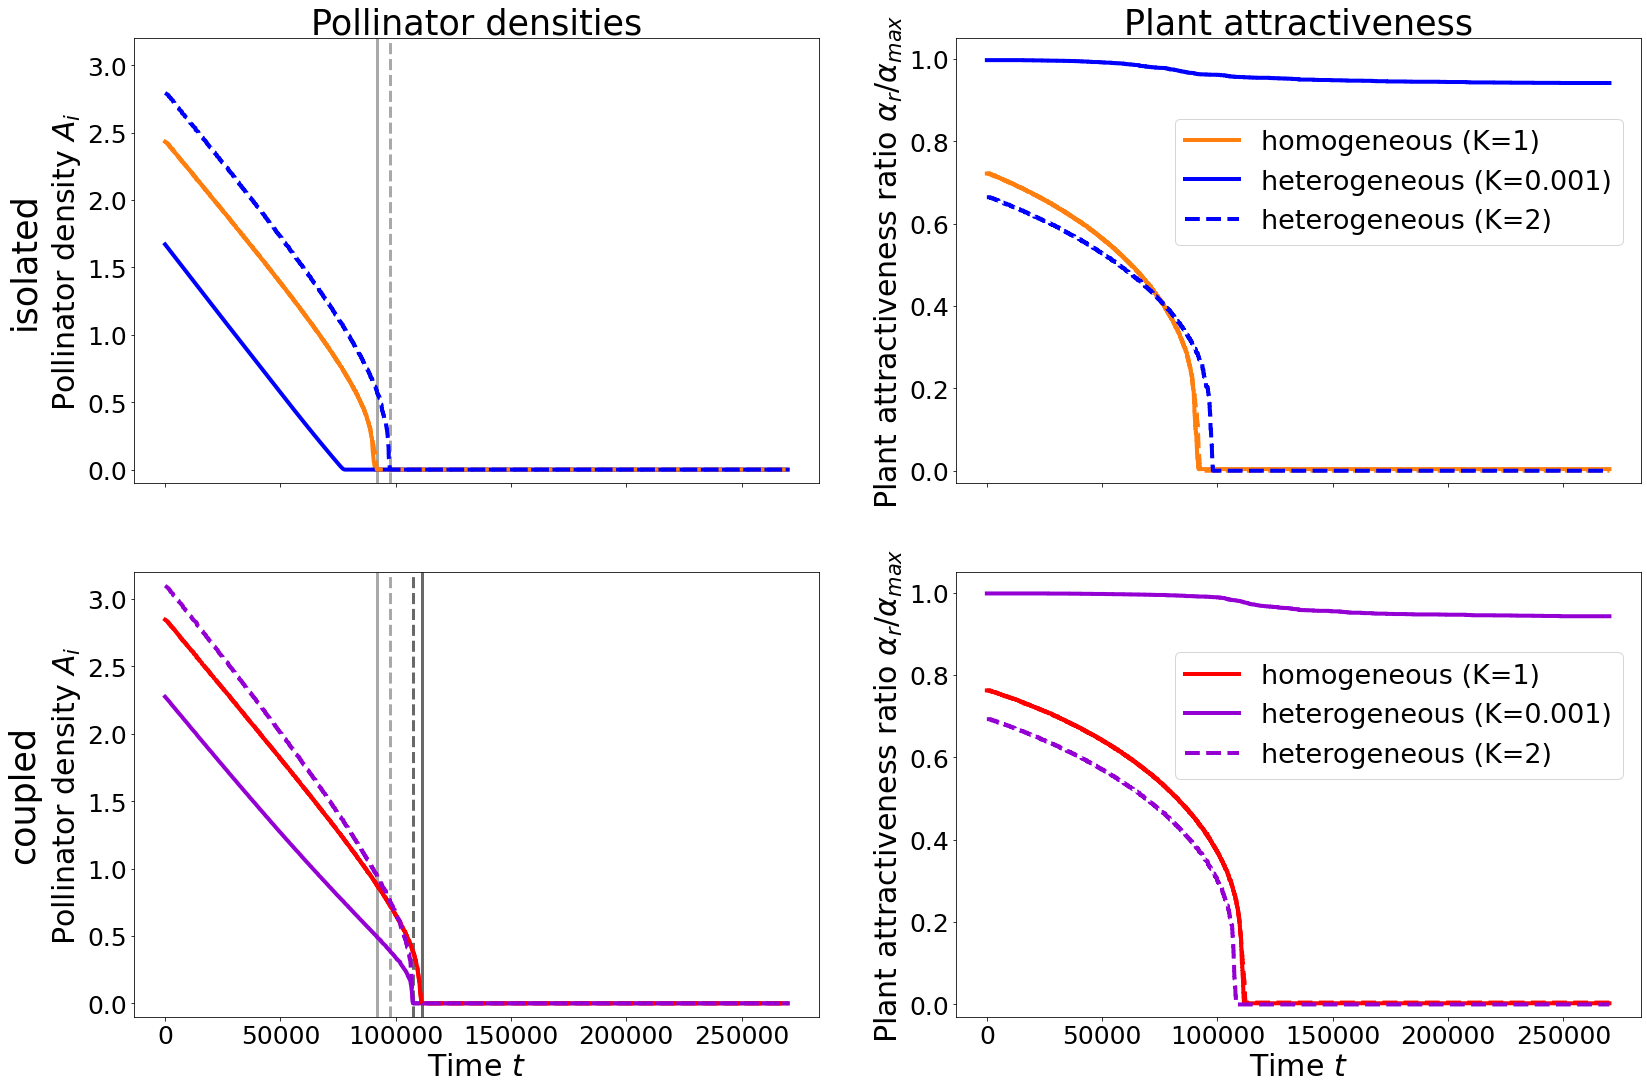

In [19]:
# code for plotting 
start=0
end=270000

linestyles = ['-', '--']

cols = ['{}'.format(col) for col in ['Pollinator densities', 'Plant attractiveness']]
rows = ['{}'.format(row) for row in ['isolated', 'coupled']]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(27,18), constrained_layout=False, sharex=True)
pad = 5 # in points

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size=35, ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=35, ha='right', va='center', rotation=90)

    
# 1st column pollinator densities
n_col=0
# 1st row isolated
n_row = 0
for i in [0,1]:
    axes[n_row, n_col].plot(t_complete[start:end],np.asarray(x_complete_0)[start:end,i*2], color='tab:orange', linestyle=linestyles[i], linewidth=4)
    axes[n_row, n_col].plot(t_complete[start:end],np.asarray(x_complete_2)[start:end,i*2], color='blue', linestyle=linestyles[i], linewidth=4)
axes[n_row, n_col].set_ylabel('Pollinator density $A_i$', size=30)
axes[n_row, n_col].set_ylim(-0.1, 3.2)
if evolution:
    axes[n_row, n_col].vlines(x=91879, ymin=-0.1, ymax=3.2, colors="darkgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=97619, ymin=-0.1, ymax=3.2, colors="darkgrey", linestyles='dashed', linewidth=3)
else:
    axes[n_row, n_col].vlines(x=203619, ymin=-0.1, ymax=3.2, colors="darkgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=251599, ymin=-0.1, ymax=3.2, colors="darkgrey", linestyles='dashed', linewidth=3)
axes[n_row, n_col].tick_params(axis='x', labelsize=25)
axes[n_row, n_col].tick_params(axis='y', labelsize=25)

# 2nd row coupled
n_row = 1
for i in [0,1]:
    axes[n_row, n_col].plot(t_complete[start:end],np.asarray(x_complete_1)[start:end,i*2], color='red', linestyle=linestyles[i], linewidth=4)
    axes[n_row, n_col].plot(t_complete[start:end],np.asarray(x_complete_3)[start:end,i*2], color='darkviolet', linestyle=linestyles[i], linewidth=4)
axes[n_row, n_col].set_xlabel('Time $t$', size=30)
axes[n_row, n_col].set_ylabel('Pollinator density $A_i$', size=30)
axes[n_row, n_col].set_ylim(-0.1, 3.2)
if evolution:
    axes[n_row, n_col].vlines(x=91879, ymin=-0.1, ymax=3.2, colors="darkgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=111379, ymin=-0.1, ymax=3.2, colors="dimgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=97619, ymin=-0.1, ymax=3.2, colors="darkgrey", linestyles='dashed', linewidth=3)
    axes[n_row, n_col].vlines(x=107659, ymin=-0.1, ymax=3.2, colors="dimgrey", linestyles='dashed', linewidth=3)
else:
    axes[n_row, n_col].vlines(x=203619, ymin=-0.1, ymax=3.2, colors="darkgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=224299, ymin=-0.1, ymax=3.2, colors="dimgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=251599, ymin=-0.1, ymax=3.2, colors="darkgrey", linestyles='dashed', linewidth=3)
    axes[n_row, n_col].vlines(x=256839, ymin=-0.1, ymax=3.2, colors="dimgrey", linestyles='dashed', linewidth=3)
axes[n_row, n_col].tick_params(axis='x', labelsize=25)
axes[n_row, n_col].tick_params(axis='y', labelsize=25)


# 2nd column plant attractivness
n_col=1
# 1st row isolated
n_row = 0
i=0
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_0, t_interval, 0))[start:end,i]/alpha_max_vals_0[i], 
                        color='tab:orange', linestyle=linestyles[i], linewidth=4, label='homogeneous (K=1)')
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_2, t_interval, 0))[start:end,i]/alpha_max_vals_2[i], 
                        color='blue', linestyle=linestyles[i], linewidth=4, label='heterogeneous (K=0.001)')
i=1
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_0, t_interval, 0))[start:end,i]/alpha_max_vals_0[i], 
                        color='tab:orange', linestyle=linestyles[i], linewidth=4)
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_2, t_interval, 0))[start:end,i]/alpha_max_vals_2[i], 
                        color='blue', linestyle=linestyles[i], linewidth=4, label='heterogeneous (K=2)')

axes[n_row, n_col].set_ylabel(r'Plant attractiveness ratio $\alpha_{r}/\alpha_{max}$', size=30)
axes[n_row, n_col].set_ylim(-0.03, 1.05)
axes[n_row, n_col].tick_params(axis='x', labelsize=25)
axes[n_row, n_col].tick_params(axis='y', labelsize=25)
if evolution:
    axes[n_row, n_col].legend(bbox_to_anchor=(0.3, 0.35, 0.5, 0.5), fontsize=27)
else:
    axes[n_row, n_col].legend(loc="lower right", fontsize=27)

# 2nd row coupled
n_row = 1
i=0
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_1, t_interval, 0))[start:end,i]/alpha_max_vals_1[i], 
                            color='red', linestyle=linestyles[i], linewidth=4, label='homogeneous (K=1)')
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_3, t_interval, 0))[start:end,i]/alpha_max_vals_3[i], 
                            color='darkviolet', linestyle=linestyles[i], linewidth=4, label='heterogeneous (K=0.001)')
i=1
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_1, t_interval, 0))[start:end,i]/alpha_max_vals_1[i], 
                            color='red', linestyle=linestyles[i], linewidth=4)
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_3, t_interval, 0))[start:end,i]/alpha_max_vals_3[i], 
                            color='darkviolet', linestyle=linestyles[i], linewidth=4, label='heterogeneous (K=2)')
axes[n_row, n_col].set_xlabel('Time $t$', size=30)
axes[n_row, n_col].set_ylabel(r'Plant attractiveness ratio $\alpha_{r}/\alpha_{max}$', size=30)
axes[n_row, n_col].set_ylim(-0.03, 1.05)
axes[n_row, n_col].tick_params(axis='x', labelsize=25)
axes[n_row, n_col].tick_params(axis='y', labelsize=25)
if evolution:
    axes[n_row, n_col].legend(bbox_to_anchor=(0.3, 0.35, 0.5, 0.5), fontsize=27)
else:
    axes[n_row, n_col].legend(loc="lower right", fontsize=27)

Corresponding PIP for $K=0.001$:

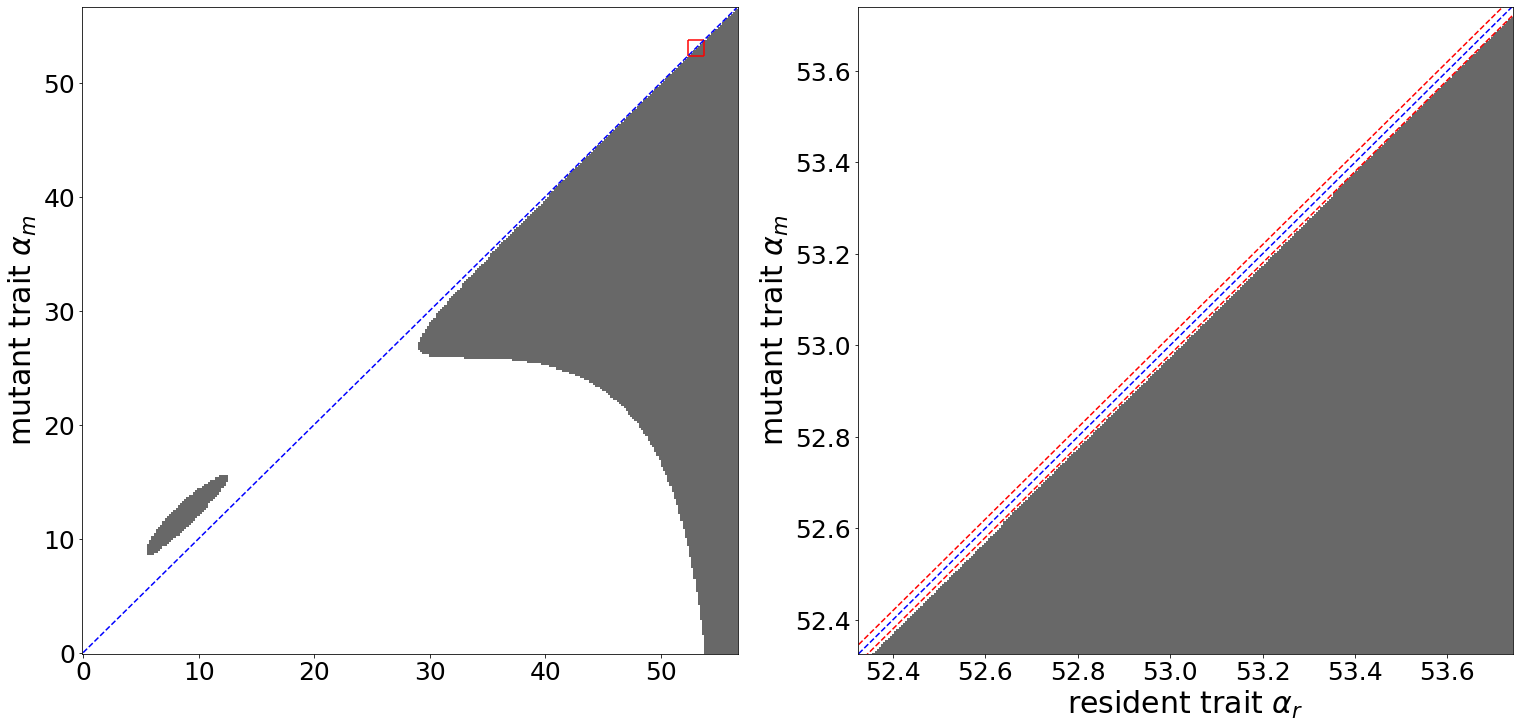

In [20]:
num_vals = 300             # number of values on the x- and y-axis
immig = 0.0                # immigration is set = 0, i.e. PIP is for an isolated patch 
r_A = 0.2                  # set pollinator growth rate
c_P = 1000                 # K = 0.001

alpha_max = 0.8*sqrt((c_A*c_P)/(gamma_A*gamma_P))

#### define zoom limits:
blim=0.925
tlim=0.95

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21,10), constrained_layout=True)

n_row=0

for n_col in [0,1]:
    
    if n_col==0:
        alpha_r_vals = np.linspace(0,alpha_max,num_vals)    # values of the resident strategy for x-axis
        alpha_m_vals = np.linspace(0,alpha_max,num_vals)    # values of the mutant strategy for y-axis
        
    if n_col==1:
        alpha_r_vals = np.linspace(blim*alpha_max, tlim*alpha_max,num_vals)    # values of the resident strategy for x-axis
        alpha_m_vals = np.linspace(blim*alpha_max, tlim*alpha_max,num_vals)    # values of the mutant strategy for y-axis
    
    P_m = 0.000001                                  # Assume a very small density for the mutant population density 

    fitness = np.zeros((num_vals,num_vals))         # empty matrix, containing only zeros

    for i in range(num_vals):                       # loop through alpha_m-values (rows in the fitness matrix)
        for j in range(num_vals):                   # loop through alpha_r-values (columns in the fitness matrix)

            alpha_m = alpha_m_vals[i]
            alpha_r = alpha_r_vals[j]

            # use trade-off function to calculate the plant growth rates       
            r_P_r = pow(( 1- pow((alpha_r/alpha_max),s)),1/s)
            r_P_m = pow(( 1- pow((alpha_m/alpha_max),s)),1/s)

            # determine equilibrium densities for resident plants and pollinators
            A_star = (alpha_r*gamma_P*r_P_r + c_P*r_A - d*c_P*(1-immig)) / (c_A* c_P-alpha_r**2*gamma_A*gamma_P)
            P_r_star = (alpha_r*gamma_A*r_A + c_A*r_P_r - d*alpha_r*gamma_A*(1-immig)) / (c_A* c_P-alpha_r**2*gamma_A*gamma_P)

            # Assume a very small density for the mutant population density 
            # Calculate the mutant's fitness (= per-capita growth rate
            fitness[i,j]= r_P_m - c_P*P_m - c_P*P_r_star + alpha_m*gamma_A*A_star

            # For colorcoding
            if  (fitness[i,j]> 0.0):
                fitness[i,j] = 1 # yellow
            if  (fitness[i,j]< 0.0):
                fitness[i,j] = -1 # purple

                
    axes[n_col].pcolor(alpha_r_vals,alpha_m_vals,fitness, shading='auto', cmap='Greys', vmin=0, vmax=1.5)
    axes[n_col].plot(alpha_r_vals,alpha_m_vals, 'b--')
    if n_col==0:
        axes[n_col].vlines(x=blim*alpha_max, ymin=blim*alpha_max, ymax=tlim*alpha_max, colors='red')
        axes[n_col].vlines(x=tlim*alpha_max, ymin=blim*alpha_max, ymax=tlim*alpha_max, colors='red')
        axes[n_col].hlines(y=blim*alpha_max, xmin=blim*alpha_max, xmax=tlim*alpha_max, colors='red')
        axes[n_col].hlines(y=tlim*alpha_max, xmin=blim*alpha_max, xmax=tlim*alpha_max, colors='red')
    if n_col==1:
        axes[n_col].plot(alpha_r_vals,alpha_m_vals-0.02, 'r--')
        axes[n_col].plot(alpha_r_vals,alpha_m_vals+0.02, 'r--')
        axes[n_col].set_ylim(blim*alpha_max, tlim*alpha_max)
        axes[n_col].set_xlabel(r'resident trait $\alpha_r$', size=30)
    #plt.title('$K = $' + str(1/c_P) + '$, r_A = $' + str(r_A), size=35)
    axes[n_col].set_ylabel(r'mutant trait $\alpha_m$', size=30)
    axes[n_col].tick_params(axis='both', labelsize=25)

#plt.savefig("PIPs inaccuracy.pdf")
plt.show();

### $P_m = 10^{-9}$

In [21]:
def evolution_function(alpha_r_vals, alpha_m_vals, r_P_r_vals, r_P_m_vals, c_P_vals, r_A, c_A, gamma_P, gamma_A, s, mut_step, d, x):
    
    '''
    This function performs the evolution of the plant attractiveness values alpha.
    With the given values the fitness of the mutant is calculated and if the fitness is positive, the resident strategy is displaced.
    A new mutant stategy is drawn randomly within a defined range close to the resident strategy.
    '''
    
    #open lists to store the new alpha values
    alpha_r_res = []
    alpha_m_res = []
    
    
    for i, alpha_r in enumerate(alpha_r_vals): #loop through the values for the different patches
        
        alpha_m = alpha_m_vals[i]
        r_P_r = r_P_r_vals[i]
        r_P_m = r_P_m_vals[i]
        c_P = c_P_vals[i]
        
        # determine equilibrium densities for resident plants and pollinators
        A_star = x[i*2]   # pollinator
        P_r_star = x[i*2+1]  # resident plant
    
        # Assume a very small density for the mutant population density 
        P_m = 0.000000001
    
        # Calculate the mutant's fitness (= per-capita growth rate)
        fitness = r_P_m - c_P*P_m - c_P*P_r_star + alpha_m*gamma_A*A_star
              
        
        # what if P_m survives?
        if fitness > 0.0:
            alpha_r = alpha_m     # new resident population with new alpha
        alpha_m = alpha_r + mut_step*(rd.random()-rd.random())      # new mutants alpha something close to residents alpha
        
        # check if alpha_m is negative, if so send it to zero:
        if alpha_m < 0.0:
            alpha_m = 0
        
        alpha_r_res.append(alpha_r)
        alpha_m_res.append(alpha_m)
        
    return [alpha_r_res, alpha_m_res]


The extinction times are printed below in the order: isolated homogeneous, coupled homogeneous, isolated heterogeneous, coupled heterogeneous.

In [22]:
t_end = 300000
environmental_change = True
#evolution = False


c_P_vals_list = [np.array([1, 1]), np.array([1, 1]), np.array([1000, 0.5]), np.array([1000, 0.5])]
delta_max_list = [0.0, 1.0, 0.0, 1.0]

for count in range(4):
    
    printed = False

    delta_max = delta_max_list[count]
    c_P_vals = c_P_vals_list[count]

    ########################### migration matrix
    success = fct_rgg.linkwise_success(delta, delta_max)

    # calculate migration frations
    fractions = fct_rgg.fractions_ij(success)

    # calculate combined miration matrix
    mig_matrix = success * fractions

    ############################# initialisation
    # population initialisation
    x0_ini, alpha_max_vals, alpha_r_vals_ini, alpha_m_vals_ini = fct_rgg.initialisation(c_P_vals, c_A, gamma_P, gamma_A, 
                                                                    s, d, r_A0, r_A_change, N, mig_matrix, 0.02)
    seeding = 1000


    '''############################ simulations ##############################'''
    # prepare empty lists to store simulation results for extinction checks

    #for evolution in [True, False]:
    x_complete = []
    t_complete = []
    f_complete = []
    r_A_vals = []
    alpha_r_complete = []
    order_of_extinction = np.zeros(N)
    
    x0 = x0_ini
    alpha_r_vals = alpha_r_vals_ini
    alpha_m_vals = alpha_m_vals_ini

    # set seed
    rd.seed(seeding)
                
    for i in range (int(t_end / t_interval)):       # loop through the time intervals

        # calculate per-capita growth rates from alpha
        r_P_r_vals = fct_rgg.r_P_function(alpha_r_vals, alpha_max_vals, s)
        r_P_m_vals = fct_rgg.r_P_function(alpha_m_vals, alpha_max_vals, s)

        # t-values for the current time interval, that is between pertubation i and pertubation i+1:
        t = np.arange(0,t_interval,t_step) + i*t_interval

        # additional parameters to give into the odeint-function
        env_params = [r_A0, r_A_change, environmental_change]
        plant_params = [alpha_r_vals, r_P_r_vals]
        migration_params =  [d, mig_matrix]

        # time series
        x = integ.odeint(fct_rgg.metacommunity,x0,t, 
                        args=(env_params, c_A, c_P_vals, gamma_A, gamma_P, plant_params, migration_params, N))

        # calculate and save overall migration success
        f = fct_rgg.overall_migration_success(x, d, mig_matrix, N)
        f = np.repeat(f, t_interval)
        f_complete.extend(f)


        # check for pollinator extinction:
        x[-1] = np.where(x[-1] < A_ext, 0, x[-1]) # when below extinction threshold send to 0

        extinct = np.array(x[-1,::2] < A_ext) # one value per pollinator population: False = alive, True = extinct
        if np.all(extinct): # when all local populations are extinct save the time
            t_extinct = t[-1]
            
            if printed == False:
                print(t_extinct)
                printed = True
        
    
        # environmental change for evolution
        if environmental_change:
            r_A = r_A0 + t * r_A_change  
        else:
            r_A = r_A0 + t * 0
        
        r_A_vals.extend(r_A)

        # save attractivity values of the current resident populations
        alpha_r_complete.append(alpha_r_vals)

        # perform evolution if activated
        if evolution:
            alpha_r_vals, alpha_m_vals = evolution_function(alpha_r_vals, alpha_m_vals, 
                                                                r_P_r_vals, r_P_m_vals, 
                                                                c_P_vals, r_A[-1], 
                                                                c_A, gamma_P, gamma_A, s, 
                                                                mut_step, d, x[-1])

        # save densities
        x0 = x[-1]    
        x_complete.extend(x)
        t_complete.extend(t)


    if count == 0:
        x_complete_0 = x_complete
        alpha_r_complete_0 = alpha_r_complete
        f_complete_0 = f_complete
        alpha_max_vals_0 = alpha_max_vals
    
    if count == 1:
        x_complete_1 = x_complete
        alpha_r_complete_1 = alpha_r_complete
        f_complete_1 = f_complete
        alpha_max_vals_1 = alpha_max_vals
        
    if count == 2:
        x_complete_2 = x_complete
        alpha_r_complete_2 = alpha_r_complete
        f_complete_2 = f_complete
        alpha_max_vals_2 = alpha_max_vals
        
    if count == 3:
        x_complete_3 = x_complete
        alpha_r_complete_3 = alpha_r_complete
        f_complete_3 = f_complete
        alpha_max_vals_3 = alpha_max_vals

91839
111339
97479
107679


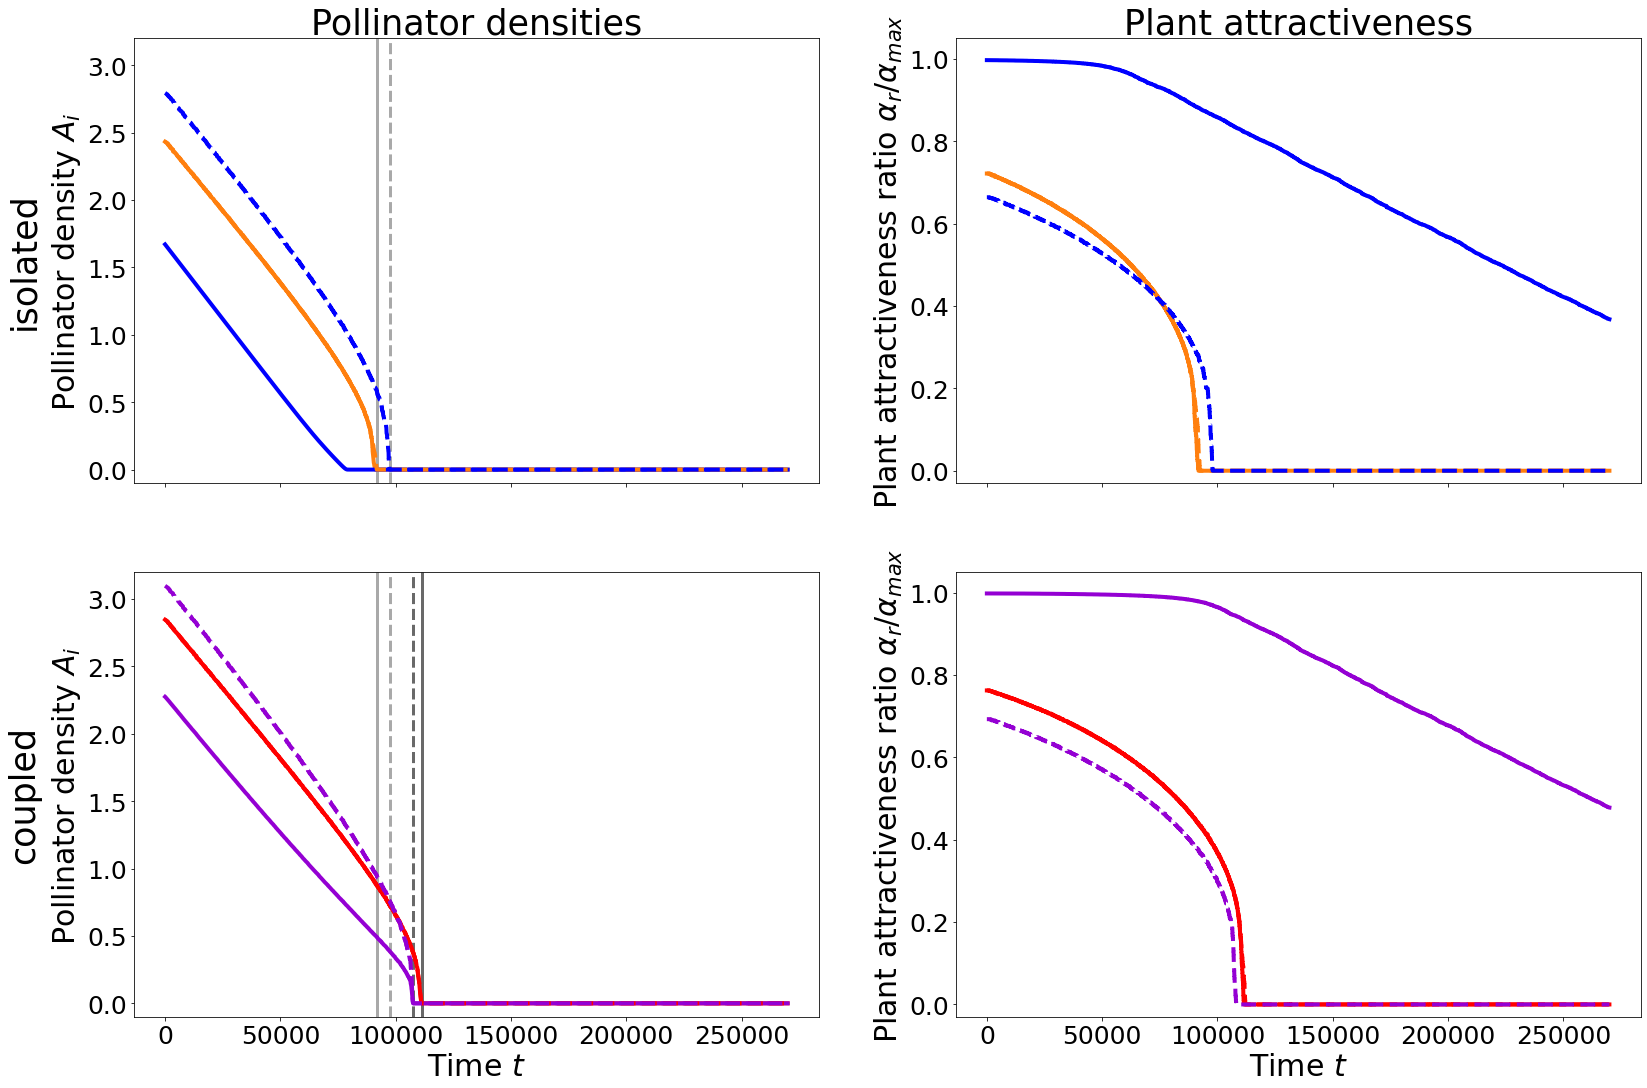

In [23]:
# code for plotting 
start=0
end=270000

linestyles = ['-', '--']

cols = ['{}'.format(col) for col in ['Pollinator densities', 'Plant attractiveness']]
rows = ['{}'.format(row) for row in ['isolated', 'coupled']]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(27,18), constrained_layout=False, sharex=True)
pad = 5 # in points

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size=35, ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=35, ha='right', va='center', rotation=90)

    
# 1st column pollinator densities
n_col=0
# 1st row isolated
n_row = 0
for i in [0,1]:
    axes[n_row, n_col].plot(t_complete[start:end],np.asarray(x_complete_0)[start:end,i*2], color='tab:orange', linestyle=linestyles[i], linewidth=4)
    axes[n_row, n_col].plot(t_complete[start:end],np.asarray(x_complete_2)[start:end,i*2], color='blue', linestyle=linestyles[i], linewidth=4)
axes[n_row, n_col].set_ylabel('Pollinator density $A_i$', size=30)
axes[n_row, n_col].set_ylim(-0.1, 3.2)
if evolution:
    axes[n_row, n_col].vlines(x=91879, ymin=-0.1, ymax=3.2, colors="darkgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=97619, ymin=-0.1, ymax=3.2, colors="darkgrey", linestyles='dashed', linewidth=3)
else:
    axes[n_row, n_col].vlines(x=203619, ymin=-0.1, ymax=3.2, colors="darkgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=251599, ymin=-0.1, ymax=3.2, colors="darkgrey", linestyles='dashed', linewidth=3)
axes[n_row, n_col].tick_params(axis='x', labelsize=25)
axes[n_row, n_col].tick_params(axis='y', labelsize=25)

# 2nd row coupled
n_row = 1
for i in [0,1]:
    axes[n_row, n_col].plot(t_complete[start:end],np.asarray(x_complete_1)[start:end,i*2], color='red', linestyle=linestyles[i], linewidth=4)
    axes[n_row, n_col].plot(t_complete[start:end],np.asarray(x_complete_3)[start:end,i*2], color='darkviolet', linestyle=linestyles[i], linewidth=4)
axes[n_row, n_col].set_xlabel('Time $t$', size=30)
axes[n_row, n_col].set_ylabel('Pollinator density $A_i$', size=30)
axes[n_row, n_col].set_ylim(-0.1, 3.2)
if evolution:
    axes[n_row, n_col].vlines(x=91879, ymin=-0.1, ymax=3.2, colors="darkgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=111379, ymin=-0.1, ymax=3.2, colors="dimgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=97619, ymin=-0.1, ymax=3.2, colors="darkgrey", linestyles='dashed', linewidth=3)
    axes[n_row, n_col].vlines(x=107659, ymin=-0.1, ymax=3.2, colors="dimgrey", linestyles='dashed', linewidth=3)
else:
    axes[n_row, n_col].vlines(x=203619, ymin=-0.1, ymax=3.2, colors="darkgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=224299, ymin=-0.1, ymax=3.2, colors="dimgrey", linestyles='solid', linewidth=3)
    axes[n_row, n_col].vlines(x=251599, ymin=-0.1, ymax=3.2, colors="darkgrey", linestyles='dashed', linewidth=3)
    axes[n_row, n_col].vlines(x=256839, ymin=-0.1, ymax=3.2, colors="dimgrey", linestyles='dashed', linewidth=3)
axes[n_row, n_col].tick_params(axis='x', labelsize=25)
axes[n_row, n_col].tick_params(axis='y', labelsize=25)


# 2nd column plant attractivness
n_col=1
# 1st row isolated
n_row = 0
i=0
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_0, t_interval, 0))[start:end,i]/alpha_max_vals_0[i], 
                        color='tab:orange', linestyle=linestyles[i], linewidth=4, label='homogeneous (K=1)')
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_2, t_interval, 0))[start:end,i]/alpha_max_vals_2[i], 
                        color='blue', linestyle=linestyles[i], linewidth=4, label='heterogeneous (K=0.001)')
i=1
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_0, t_interval, 0))[start:end,i]/alpha_max_vals_0[i], 
                        color='tab:orange', linestyle=linestyles[i], linewidth=4)
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_2, t_interval, 0))[start:end,i]/alpha_max_vals_2[i], 
                        color='blue', linestyle=linestyles[i], linewidth=4, label='heterogeneous (K=2)')

axes[n_row, n_col].set_ylabel(r'Plant attractiveness ratio $\alpha_{r}/\alpha_{max}$', size=30)
axes[n_row, n_col].set_ylim(-0.03, 1.05)
axes[n_row, n_col].tick_params(axis='x', labelsize=25)
axes[n_row, n_col].tick_params(axis='y', labelsize=25)


# 2nd row coupled
n_row = 1
i=0
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_1, t_interval, 0))[start:end,i]/alpha_max_vals_1[i], 
                            color='red', linestyle=linestyles[i], linewidth=4, label='homogeneous (K=1)')
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_3, t_interval, 0))[start:end,i]/alpha_max_vals_3[i], 
                            color='darkviolet', linestyle=linestyles[i], linewidth=4, label='heterogeneous (K=0.001)')
i=1
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_1, t_interval, 0))[start:end,i]/alpha_max_vals_1[i], 
                            color='red', linestyle=linestyles[i], linewidth=4)
axes[n_row, n_col].plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete_3, t_interval, 0))[start:end,i]/alpha_max_vals_3[i], 
                            color='darkviolet', linestyle=linestyles[i], linewidth=4, label='heterogeneous (K=2)')
axes[n_row, n_col].set_xlabel('Time $t$', size=30)
axes[n_row, n_col].set_ylabel(r'Plant attractiveness ratio $\alpha_{r}/\alpha_{max}$', size=30)
axes[n_row, n_col].set_ylim(-0.03, 1.05)
axes[n_row, n_col].tick_params(axis='x', labelsize=25)
axes[n_row, n_col].tick_params(axis='y', labelsize=25)